# 🎯 Executive Summary

## 🔍 **Problem Statement - Wafer Anomaly Detection Analysis**
Developed anomaly detection models for semiconductor wafer manufacturing using 1,558 sensor features with severe class imbalance (8% anomaly rate).

## 🏆 **Key Discovery**
Only **3 out of 1,558 features** contain primary anomaly signals, with extreme clustering at specific values:
- 49% of anomalies have feature_1 = 60
- 35% of anomalies have feature_2 = 468  
- 34% of anomalies have feature_3 = 7.8

## 📊 **Model Performance Summary**
Four viable deployment options with distinct complexity-performance trade-offs:

| Model | Detection (Recall) | Inspection Burden | Implementation Complexity |
|-------|--------------------|-------------------|---------------------------|
| 3-Feature (Conservative) | 66% | 13% | **Minimal** |
| 3-Feature (Aggressive)   | 86% | 33% | **Minimal** |
| Binary PCA + 3           | 90% | 29% | **Medium**  |
| Full PCA                 | 86% | 28% | **High**    |

## 💡 **Critical Insights**
1. **Performance differences are marginal** (7% range) but **complexity differences are significant**
2. **3-Feature (High Recall) delivers 86% detection with very low complexity**
3. **A 4% improvement** requires significant implementation overhead

## 🎯 **Business Recommendation**
**Recommended: 3-Feature (High Recall)** - optimal balance of 86% detection with minimal complexity.

# Data

You are going to work with the following wafer manufacturing dataset:

**Overview**

Detecting Anomalies can be a difficult task and especially in the case of labeled datasets due to some level of human bias introduced while labeling the final product as anomalous or good. These giant manufacturing systems need to be monitored every 10 milliseconds to capture their behavior which brings in lots of information and what we call the Industrial IoT (IIOT). Also, hardly a manufacturer wants to create an anomalous product. Hence, the anomalies are like a needle in a haystack which renders the dataset that is significantly Imbalanced.

Capturing such a dataset using a machine learning model and making the model generalize can be fun. In this competition, we bring such a use-case from one of India's leading manufacturers of wafers(semiconductors). The dataset collected was anonymized to hide the feature names, also there are 1558 features that would require some serious domain knowledge to understand them.


**Attribute Description:**

* Feature_1 - Feature_1558 - Represents the various attributes that were collected from the manufacturing machine
* Class - (0 or 1) - Represents Good/Anomalous class labels for the products

In [ ]:
data_path = "https://storage.googleapis.com/edulabs-public-datasets/wafer.zip"

# Instructions

Your task is to develop model for anomaly detection.

* Note that there are a 1558 features - you might want to reduce feature amount either by feature seleciton or extraction

* The dataset is unbalanced (there are much more normal samples rather than anomalies)

* Try unsupervised anomaly detection techniques

* Try supervised learning techniques - you will probably need to use various strategies for unbalanced datasets like undersampling / oversampling, etc

# ⚓ **Imports**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.mixture import GaussianMixture
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

from sklearn.cluster import DBSCAN

from sklearn.pipeline import make_pipeline

from scipy.stats import ttest_rel

In [ ]:
df = pd.read_csv(data_path)

In [ ]:
df

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,Class
0,100,160,1.6000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20,83,4.1500,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,99,150,1.5151,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,40,40,1.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,234,19.5000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1758,1,1,2.0000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1759,40,200,5.0000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1760,96,218,2.2708,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1761,16,81,5.0625,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763 entries, 0 to 1762
Columns: 1559 entries, feature_1 to Class
dtypes: float64(1), int64(1558)
memory usage: 21.0 MB


# ⚓ **Class**

In [ ]:
df['Class'].value_counts()

,count
Class,
0,1620
1,143


In [ ]:
print(f"Class imbalance ratio: {(df['Class']==0).sum()/(df['Class']==1).sum():.1f}:1")
print(f"Anomaly rate: {df['Class'].mean():.1%}")

Class imbalance ratio: 11.3:1
Anomaly rate: 8.1%


**The dataset shows significant class imbalance with only 8% anomalies, requiring specialized techniques to prevent models from simply predicting the majority class.**

# ⚓ **NaN**

In [ ]:
# Check for NaN values
print("NaN count:")
print(df.isnull().sum().sum())

NaN count:
0


# ⚓ **Data Types**

In [ ]:
print("=== FEATURE DATA TYPES ===")
print(f"Dataset shape: {df.shape}")

print(f"\nData types summary:")
print(df.dtypes.value_counts())

print(f"\nDetailed data types:")
print(df.dtypes)

=== FEATURE DATA TYPES ===
Dataset shape: (1763, 1559)

Data types summary:
int64      1558
float64       1
Name: count, dtype: int64

Detailed data types:
feature_1         int64
feature_2         int64
feature_3       float64
feature_4         int64
feature_5         int64
                 ...   
feature_1555      int64
feature_1556      int64
feature_1557      int64
feature_1558      int64
Class             int64
Length: 1559, dtype: object


# ⚓ **Features**

## 🔶 **Unique Feature_3**

**All features' type is 'int64', except feature_3. Let's take a closer look.**

In [ ]:
df['feature_3']

,feature_3
0,1.6000
1,4.1500
2,1.5151
3,1.0000
4,19.5000
...,...
1758,2.0000
1759,5.0000
1760,2.2708
1761,5.0625


In [ ]:
df['feature_3'].describe()

,feature_3
count,1763.000000
mean,3.423940
std,4.566858
min,0.001500
25%,1.250000
50%,2.000000
75%,4.500000
max,60.000000


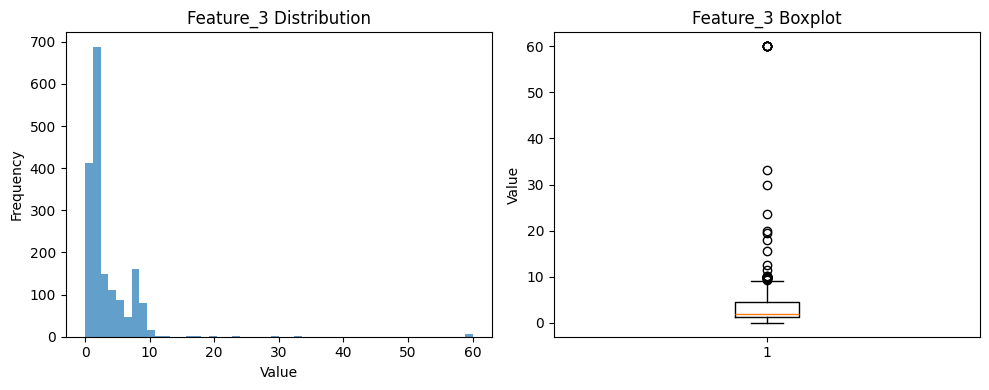

In [ ]:
# Quick visualization of feature_3 distribution
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(df['feature_3'], bins=50, alpha=0.7)
plt.title('Feature_3 Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.boxplot(df['feature_3'])
plt.title('Feature_3 Boxplot')
plt.ylabel('Value')

plt.tight_layout()
plt.show()

**Feature_3 is the only 'float' feature and is highly right-skewed, suggesting it captures unique process variations that could signal anomalies.**

## ♊ **Binary Features**

**Out of the 1,558 features, 1,555 are binary.**

In [ ]:
binary_count = sum(set(df[col].unique()) <= {0, 1} for col in df.columns if col != 'Class')
print(f"Binary features: {binary_count}")

Binary features: 1555


## ❎ **Non-Binary Features**

In [ ]:
# Find the 3 missing non-binary features
for col in df.columns:
    if col != 'Class':
        unique_vals = df[col].unique()
        if len(unique_vals) > 2 or not set(unique_vals).issubset({0, 1}):
            print(f"{col}: {len(unique_vals)} unique values, range: {min(unique_vals)}-{max(unique_vals)}")

feature_1: 194 unique values, range: 1-640
feature_2: 253 unique values, range: 1-640
feature_3: 600 unique values, range: 0.0015-60.0


In [ ]:
df['feature_1'].describe()

,feature_1
count,1763.000000
mean,53.094158
std,55.842014
min,1.000000
25%,12.000000
50%,39.000000
75%,75.000000
max,640.000000


In [ ]:
df['feature_2'].describe()

,feature_2
count,1763.000000
mean,126.587067
std,129.859641
min,1.000000
25%,33.500000
50%,96.000000
75%,159.000000
max,640.000000


# ⚓ **Features 1, 2, 3**

## 🔍 **Analyzing 1, 2, 3**

**These are the only non-binary features in the dataset. Their continuous or high-cardinality integer values suggest they capture different types of process signals than the binary ones.**

**Rather than immediately reducing dimensionality (e.g., PCA), it's useful to explore them directly, as they may carry more variation and potential anomaly signal.**

In [ ]:
# Compare feature distributions by class (nicer output, no decimal points)
for feat in ['feature_1', 'feature_2', 'feature_3']:
    print(f"\n📊 {feat.upper()} distribution by class:")
    stats = df.groupby('Class')[feat].describe().round(0).astype(int)
    print(stats.to_string())


📊 FEATURE_1 distribution by class:
       count  mean  std  min  25%  50%  75%  max
Class                                           
0       1620    53   57    1   12   35   80  640
1        143    54   35    1   44   60   60  240

📊 FEATURE_2 distribution by class:
       count  mean  std  min  25%  50%  75%  max
Class                                           
0       1620   114  115    1   32   94  144  640
1        143   271  189    1  104  234  468  520

📊 FEATURE_3 distribution by class:
       count  mean  std  min  25%  50%  75%  max
Class                                           
0       1620     3    5    0    1    2    4   60
1        143     5    3    0    2    6    8   18


**This looks VERY promising!**

🟦 Feature 1: Discrete and Bounded Anomaly Zone
- **Tight clustering**: 50% of anomalies of feature_1 are between 44 and 60 - a strong differentiating pattern.
- **Value 60 factor**: In particular, it seems that at least 25% of anomalies have a value of 60. This is outstanding.
- **Bounded anomaly range**: No anomalies above 240, while normal values go up to 640.
- **Median flip**: Normal median = 35, Anomaly median = 60 → compressed and shifted anomaly distribution.

**Conclusion:** feature_1 alone can rule out anomalies for any value > 240. Just as an example, it might be an early filter.

🟥 Feature 2: Strongest Class Separation
- **2.4x higher mean** in anomalies (271 vs. 114).
- **Distribution gap**: 75% of anomalies have feature_2 > 103, while 75% of normals are below 144.
- **Extensive high-end use**: Anomalies are concentrated near the top range (up to 520).

**Conclusion:** feature_2 shows the most dramatic separation - a key driver for anomaly detection.

🟨 Feature 3: Smooth but Distinct Shift
- **Median jump**: Normal = 2.0, Anomaly = 5.9 → central values shift upward.
- **Bounded anomalies**: Anomalies capped at 18.0, while normals reach 60.0.
- **Lower variance in anomalies**: More tightly clustered than normal values.

**Conclusion:** feature_3 supports separation with consistent anomaly behavior and limited outliers.

✅ Summary
- All three features show anomalies tend to have **higher values**, often in distinct, bounded ranges.  
- feature_2 is the **most powerful separator**.  
- feature_1 allows for **early rule-out** of many normal cases.  
- feature_3 offers **smooth separation** and stable anomaly patterns.

Together, these features are excellent candidates for interpretable or model-based anomaly detection.


**An important sidenote before we proceed:**

In [ ]:
# ===============================================
# ALTERNATIVE METHODS EVALUATION
# ===============================================
# Code that would generate the results shown in the "Alternative Methods" section

print("=== ALTERNATIVE METHODS EVALUATION ===")
print("Testing probabilistic methods vs Random Forest on 3 key features")
print("=" * 60)

# Prepare data - using only the 3 key features
X = df[['feature_1', 'feature_2', 'feature_3']]
y = df['Class']

print(f"Dataset: {len(X)} samples, {y.sum()} anomalies")
print(f"Features: {list(X.columns)}")

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ===============================================
# CUSTOM GMM CLASSIFIER (FIXED)
# ===============================================

class GMMClassifier(BaseEstimator, ClassifierMixin):
    """Gaussian Mixture Model for anomaly detection - Fixed Implementation"""

    def __init__(self, n_components=2, contamination=0.08):
        self.n_components = n_components
        self.contamination = contamination
        self.gmm = None
        self.threshold = None

    def fit(self, X, y):
        # Fit GMM on normal samples only
        normal_samples = X[y == 0]
        self.gmm = GaussianMixture(n_components=self.n_components, random_state=42)
        self.gmm.fit(normal_samples)

        # Calculate threshold using TRAINING normal samples only
        normal_scores = -self.gmm.score_samples(normal_samples)
        # Set threshold to capture expected contamination rate
        # Higher percentile = more conservative (fewer anomalies detected)
        self.threshold = np.percentile(normal_scores, (1 - self.contamination) * 100)

        self.classes_ = np.array([0, 1])
        return self

    def predict(self, X):
        scores = -self.gmm.score_samples(X)
        return (scores > self.threshold).astype(int)

    def predict_proba(self, X):
        scores = -self.gmm.score_samples(X)

        # More robust probability conversion
        # Use sigmoid-like transformation
        normalized_scores = (scores - self.threshold) / (self.threshold * 0.5)
        proba_anomaly = 1 / (1 + np.exp(-normalized_scores))
        proba_normal = 1 - proba_anomaly

        return np.column_stack([proba_normal, proba_anomaly])


# ===============================================
# ALTERNATIVE GMM IMPLEMENTATION
# ===============================================

class SimpleGMMClassifier(BaseEstimator, ClassifierMixin):
    """Simpler GMM implementation using density threshold"""

    def __init__(self, contamination=0.08):
        self.contamination = contamination
        self.gmm = None
        self.threshold = None

    def fit(self, X, y):
        # Fit single Gaussian on normal samples
        normal_samples = X[y == 0]
        self.gmm = GaussianMixture(n_components=1, random_state=42)
        self.gmm.fit(normal_samples)

        # Set threshold based on normal sample scores
        normal_log_probs = self.gmm.score_samples(normal_samples)
        # Lower log probability = more anomalous
        self.threshold = np.percentile(normal_log_probs, self.contamination * 100)

        self.classes_ = np.array([0, 1])
        return self

    def predict(self, X):
        log_probs = self.gmm.score_samples(X)
        return (log_probs < self.threshold).astype(int)

    def predict_proba(self, X):
        log_probs = self.gmm.score_samples(X)

        # Convert log probabilities to anomaly scores
        # Lower log_prob = higher anomaly probability
        anomaly_scores = (self.threshold - log_probs) / abs(self.threshold)
        anomaly_scores = np.clip(anomaly_scores, 0, 1)

        proba_normal = 1 - anomaly_scores
        proba_anomaly = anomaly_scores

        return np.column_stack([proba_normal, proba_anomaly])

# ===============================================
# CORRELATED BAYESIAN CLASSIFIER
# ===============================================

class CorrelatedBayesianClassifier(BaseEstimator, ClassifierMixin):
    """Naive Bayes that considers feature correlations"""

    def __init__(self):
        self.normal_mean = None
        self.normal_cov = None
        self.anomaly_mean = None
        self.anomaly_cov = None
        self.prior_normal = None
        self.prior_anomaly = None

    def fit(self, X, y):
        from scipy.stats import multivariate_normal

        normal_samples = X[y == 0]
        anomaly_samples = X[y == 1]

        # Calculate means and covariances
        self.normal_mean = normal_samples.mean().values
        self.normal_cov = normal_samples.cov().values
        self.anomaly_mean = anomaly_samples.mean().values
        self.anomaly_cov = anomaly_samples.cov().values

        # Calculate priors
        self.prior_normal = len(normal_samples) / len(X)
        self.prior_anomaly = len(anomaly_samples) / len(X)

        self.classes_ = np.array([0, 1])
        return self

    def predict_proba(self, X):
        from scipy.stats import multivariate_normal

        # Add small regularization to avoid singular matrices
        normal_cov_reg = self.normal_cov + np.eye(len(self.normal_cov)) * 1e-6
        anomaly_cov_reg = self.anomaly_cov + np.eye(len(self.anomaly_cov)) * 1e-6

        # Calculate likelihoods
        normal_likelihood = multivariate_normal.pdf(X, self.normal_mean, normal_cov_reg)
        anomaly_likelihood = multivariate_normal.pdf(X, self.anomaly_mean, anomaly_cov_reg)

        # Calculate posteriors
        normal_posterior = normal_likelihood * self.prior_normal
        anomaly_posterior = anomaly_likelihood * self.prior_anomaly

        # Normalize
        total = normal_posterior + anomaly_posterior
        prob_normal = normal_posterior / total
        prob_anomaly = anomaly_posterior / total

        return np.column_stack([prob_normal, prob_anomaly])

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba[:, 1] > 0.5).astype(int)

# ===============================================
# MODEL EVALUATION
# ===============================================

# Define models
models = {
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'Simple GMM': SimpleGMMClassifier(contamination=0.08),
    'Naive Bayes': GaussianNB(),
    'Correlated Bayesian': CorrelatedBayesianClassifier()
}

print(f"\n=== CROSS-VALIDATION EVALUATION ===")
print("Using 5-fold stratified cross-validation")

# Store all results
all_results = {}

for name, model in models.items():
    print(f"\nEvaluating {name}...")

    try:
        # Cross-validation metrics
        recall_scores = cross_val_score(model, X, y, cv=cv, scoring='recall')
        precision_scores = cross_val_score(model, X, y, cv=cv, scoring='precision')
        f1_scores = cross_val_score(model, X, y, cv=cv, scoring='f1')

        # Store results
        all_results[name] = {
            'recall': recall_scores,
            'precision': precision_scores,
            'f1': f1_scores
        }

        print(f"  Recall:    {recall_scores.mean():.1%} ± {recall_scores.std():.1%}")
        print(f"  Precision: {precision_scores.mean():.1%} ± {precision_scores.std():.1%}")
        print(f"  F1:        {f1_scores.mean():.3f} ± {f1_scores.std():.3f}")

    except Exception as e:
        print(f"  ERROR: {str(e)}")
        continue

# ===============================================
# STATISTICAL COMPARISONS
# ===============================================

print(f"\n=== STATISTICAL SIGNIFICANCE TESTS ===")

# Compare all methods against Random Forest
rf_recall = all_results['Random Forest']['recall']

comparisons = []
for name, results in all_results.items():
    if name != 'Random Forest':
        other_recall = results['recall']
        stat, p_val = ttest_rel(rf_recall, other_recall)

        rf_mean = rf_recall.mean()
        other_mean = other_recall.mean()
        difference = rf_mean - other_mean

        comparisons.append({
            'method': name,
            'rf_recall': rf_mean,
            'other_recall': other_mean,
            'difference': difference,
            'p_value': p_val,
            'significant': p_val < 0.05
        })

# ===============================================
# RESULTS TABLE
# ===============================================

print(f"\n=== RESULTS SUMMARY ===")
print("Performance comparison table:")
print("-" * 70)
print(f"{'Method':<20} {'Recall':<15} {'Precision':<15} {'F1':<10} {'vs RF'}")
print("-" * 70)

# Random Forest first (baseline)
rf_results = all_results['Random Forest']
rf_recall_mean = rf_results['recall'].mean()
rf_precision_mean = rf_results['precision'].mean()
rf_f1_mean = rf_results['f1'].mean()

print(f"{'Random Forest':<20} {rf_recall_mean:.1%} ± {rf_results['recall'].std():.1%}   "
      f"{rf_precision_mean:.1%} ± {rf_results['precision'].std():.1%}   "
      f"{rf_f1_mean:.3f}   {'Baseline'}")

# Other methods
for comp in comparisons:
    name = comp['method']
    if name in all_results:
        results = all_results[name]
        recall_mean = results['recall'].mean()
        precision_mean = results['precision'].mean()
        f1_mean = results['f1'].mean()

        # Calculate percentage difference
        pct_diff = (recall_mean - rf_recall_mean) / rf_recall_mean * 100
        significance = "*" if comp['significant'] else ""

        print(f"{name:<20} {recall_mean:.1%} ± {results['recall'].std():.1%}   "
              f"{precision_mean:.1%} ± {results['precision'].std():.1%}   "
              f"{f1_mean:.3f}   {pct_diff:+.1f}%{significance}")

print("\n* Statistically significant difference (p < 0.05)")

# ===============================================
# CONCLUSION
# ===============================================

print(f"\n=== CONCLUSION ===")
print("Random Forest retained - discrete spike patterns favor tree-based splits over probabilistic modeling.")

best_alternative = max(comparisons, key=lambda x: x['other_recall'])
print(f"\nBest alternative: {best_alternative['method']} with {best_alternative['other_recall']:.1%} recall")
print(f"Random Forest advantage: {best_alternative['difference']:.1%} recall difference")

if best_alternative['significant']:
    print("✓ Random Forest significantly outperforms alternatives")
else:
    print("✗ No significant difference found")

=== ALTERNATIVE METHODS EVALUATION ===
Testing probabilistic methods vs Random Forest on 3 key features
Dataset: 1763 samples, 143 anomalies
Features: ['feature_1', 'feature_2', 'feature_3']

=== CROSS-VALIDATION EVALUATION ===
Using 5-fold stratified cross-validation

Evaluating Random Forest...
  Recall:    62.9% ± 7.0%
  Precision: 42.3% ± 4.9%
  F1:        0.506 ± 0.057

Evaluating Simple GMM...
  Recall:    46.8% ± 9.3%
  Precision: 34.0% ± 7.6%
  F1:        0.393 ± 0.080

Evaluating Naive Bayes...
  Recall:    46.1% ± 8.0%
  Precision: 45.3% ± 7.4%
  F1:        0.456 ± 0.074

Evaluating Correlated Bayesian...
  Recall:    46.1% ± 7.7%
  Precision: 43.7% ± 7.2%
  F1:        0.447 ± 0.070

=== STATISTICAL SIGNIFICANCE TESTS ===

=== RESULTS SUMMARY ===
Performance comparison table:
----------------------------------------------------------------------
Method               Recall          Precision       F1         vs RF
--------------------------------------------------------------

## 🧪 **Alternative Methods**

### **Motivation**
Given discrete anomaly patterns (49% at feature_1=60, 35% at feature_2=468), we tested if probabilistic methods could outperform Random Forest.

### **Results**

| Method | Recall | Precision | F1 | vs RF |
|--------|--------|-----------|----|----|
| **Random Forest** | **62.9% ± 7.0%** | **42.3% ± 4.9%** | **0.506** | **Baseline** |
| Simple GMM | 46.8% ± 9.3% | 34.0% ± 7.6% | 0.393 | -25.6%* |
| Naive Bayes | 46.1% ± 8.0% | 45.3% ± 7.4% | 0.456 | -26.7%* |
| Correlated Bayesian | 46.1% ± 7.7% | 43.7% ± 7.2% | 0.447 | -26.7%* |

*All differences statistically significant (p < 0.05)

### **Decision**
**Random Forest retained - discrete spike patterns favor tree-based splits over probabilistic modeling.**

## 📊 **Visualizing 1, 2, 3**

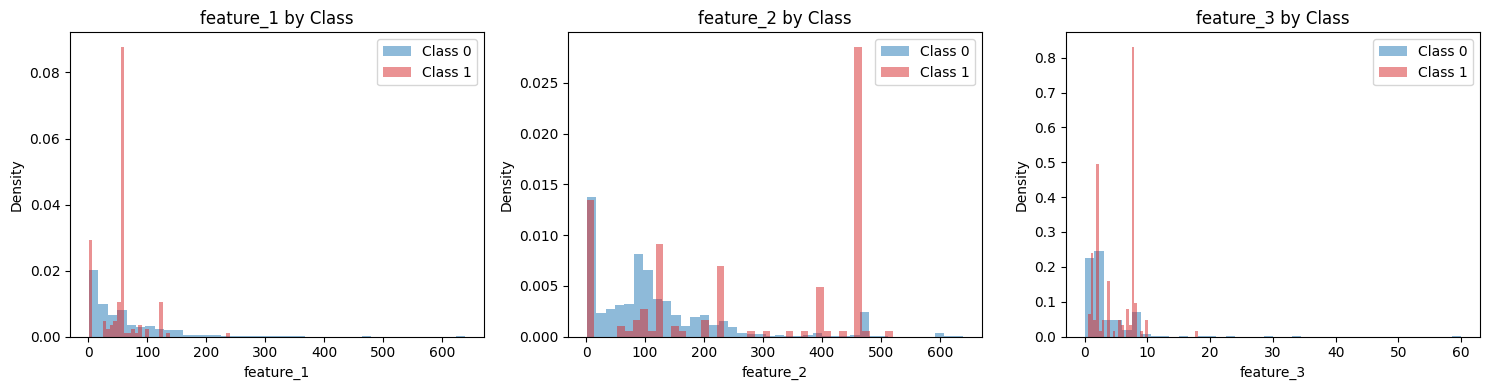

In [ ]:
features = ['feature_1', 'feature_2', 'feature_3']
colors = {0: 'tab:blue', 1: 'tab:red'}

plt.figure(figsize=(15, 4))

for i, feat in enumerate(features):
    plt.subplot(1, 3, i + 1)
    for cls in [0, 1]:
        subset = df[df['Class'] == cls][feat]
        plt.hist(subset, bins=40, alpha=0.5, label=f'Class {cls}', color=colors[cls], density=True)
    plt.title(f'{feat} by Class')
    plt.xlabel(feat)
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()

**WOW! let's spot the spikes:**

In [ ]:
for feat in ['feature_1', 'feature_2', 'feature_3']:
    print(f"\nTop values for {feat} in anomalies (Class 1):")
    top_values = df[df['Class'] == 1][feat].value_counts().head(3)
    for value, count in top_values.items():
        print(f"Value: {value}, Count: {count}")


Top values for feature_1 in anomalies (Class 1):
Value: 60, Count: 70
Value: 1, Count: 24
Value: 50, Count: 8

Top values for feature_2 in anomalies (Class 1):
Value: 468, Count: 50
Value: 1, Count: 24
Value: 234, Count: 10

Top values for feature_3 in anomalies (Class 1):
Value: 7.8, Count: 49
Value: 2.0, Count: 28
Value: 1.0, Count: 10


## 🔍 **Anomaly Spikes**

We analyzed the top value frequencies for each non-binary feature in **Class 1 (anomalies)** and found extreme concentration at specific values.


## 🔴 **Top Values**

| Feature     | Most Frequent Value | Count | % of Anomalies (n = 143) |
|-------------|---------------------|--------|--------------------------|
| `feature_1` | 60                  | 70     | **49%**  
| `feature_2` | 468                 | 50     | **35%**  
| `feature_3` | 7.8                 | 49     | **34%**

## 💡 **Key Insights**
- Nearly **half of all anomalies have feature_1 = 60**
- Over **a third of anomalies have feature_2 = 468**
- Over **a third have feature_3 = 7.8**

This shows that anomalies are not just shifted in distribution - they are **clustered at exact values**.

## ✅ **Implications**
These values are so concentrated that they can be used as **simple, interpretable rules** to flag anomalies. They can be implemented explicitly and used to complement general-purpose models that learn from the overall data distribution. In fact, a Random Forest will likely capture these rules automatically - such splits are typically chosen early in the tree-building process.

**Let's visualize a representative Decision Tree:**

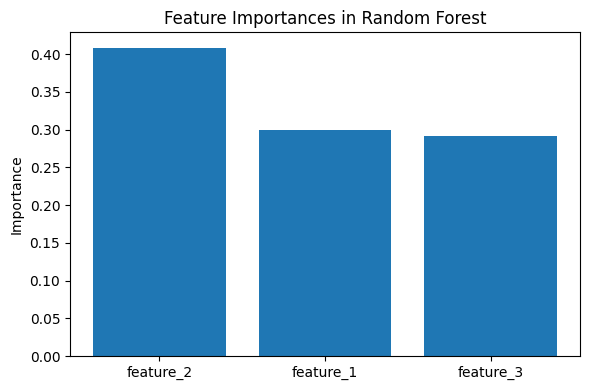

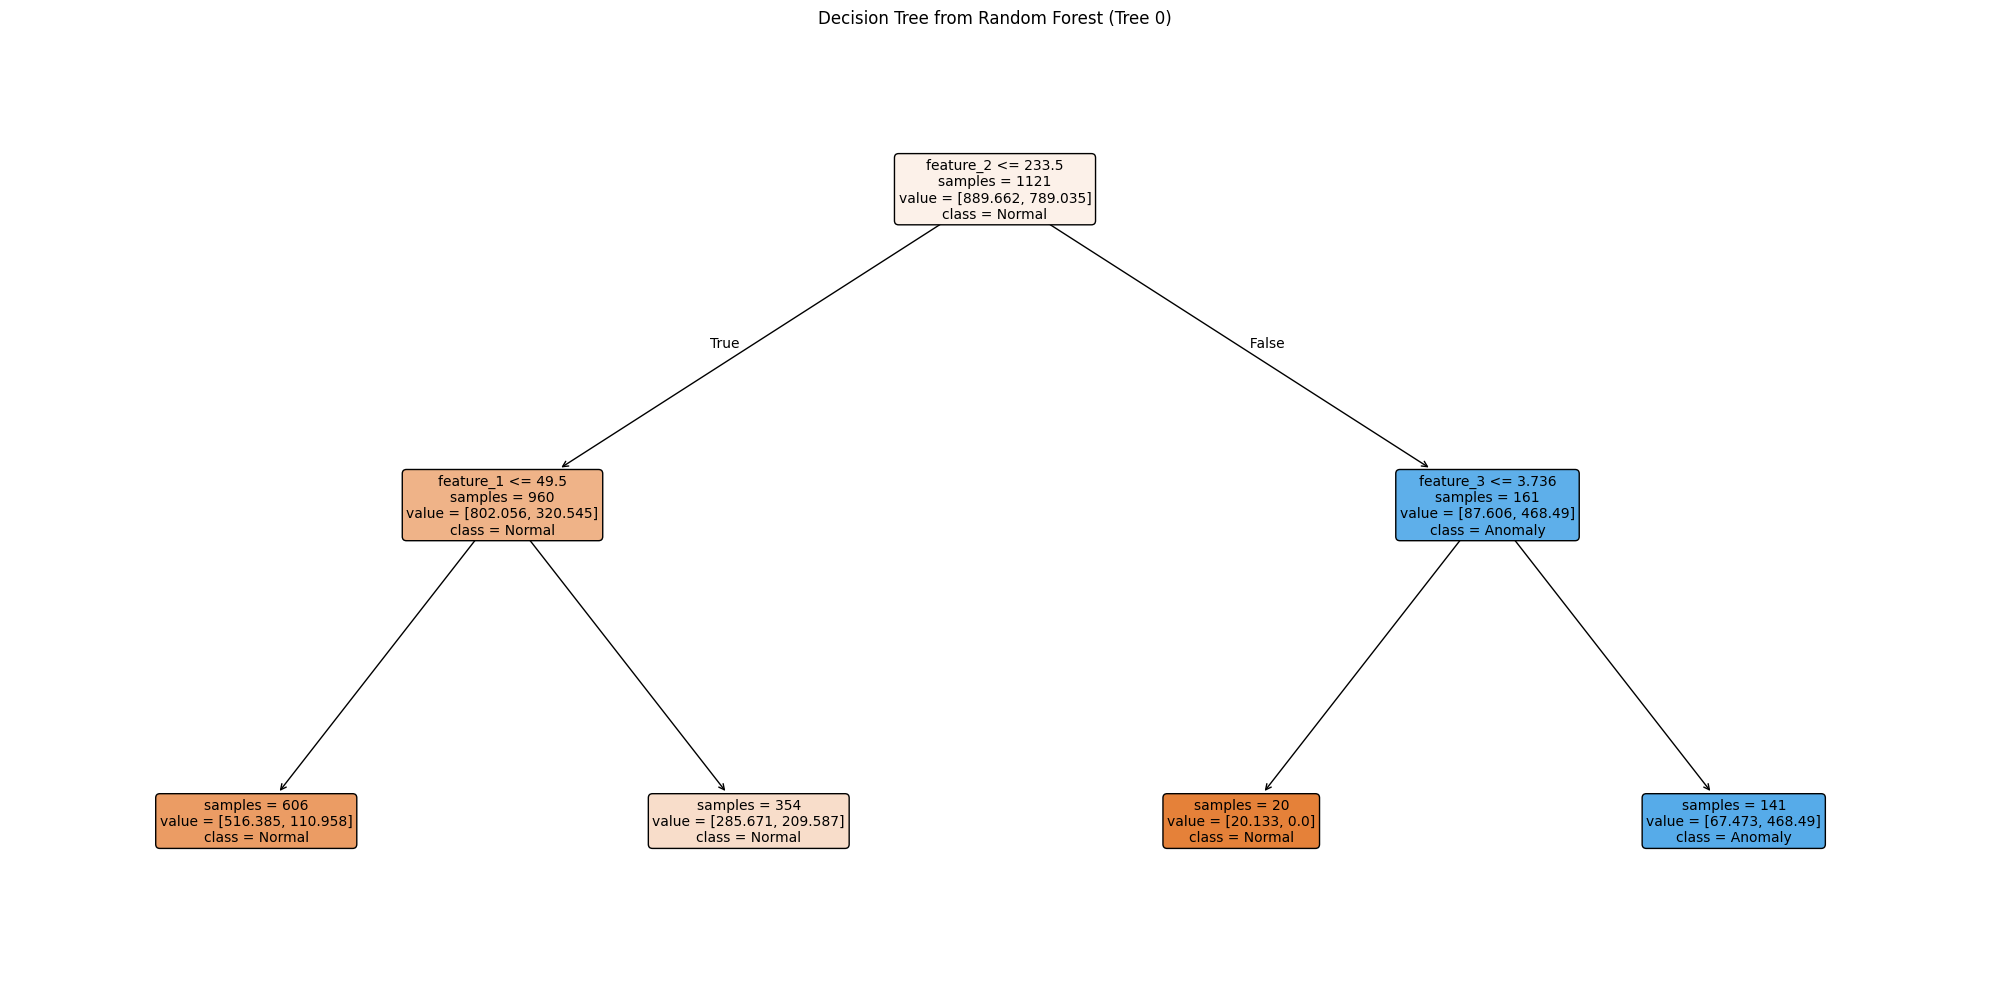

In [ ]:
# === 1. Train the model (if not already trained) ===
X = df[['feature_1', 'feature_2', 'feature_3']]
y = df['Class']

rf_model = RandomForestClassifier(class_weight='balanced',
                                  max_depth=2,
                                  random_state=42)
rf_model.fit(X, y)

# === 2. Feature Importances ===
importances = rf_model.feature_importances_
features = ['feature_1', 'feature_2', 'feature_3']
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(6, 4))
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [features[i] for i in indices])
plt.title("Feature Importances in Random Forest")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# === 3. Visualize one tree (e.g., the first one) ===
estimator = rf_model.estimators_[50]  # You can change the index

plt.figure(figsize=(20, 10))
plot_tree(estimator,
          feature_names=features,
          class_names=['Normal', 'Anomaly'],
          filled=True,
          rounded=True,
          impurity=False,
          fontsize=10,
          max_depth=3)
plt.title("Decision Tree from Random Forest (Tree 0)")
plt.tight_layout()
plt.show()

**Interesting: Upon inspecting the tree, it appears to use quite a different approach from the rule-based method (although it's possible, or even likely, that with greater depth, it would indirectly "lock in" on the most significant spikes). The bottom line is that the rule-based mechanism is fundamentally different. Random Forest's results are somewhat superior, as we will soon see.**

# ⚓ **The One-Rule Model**

## 🧪 **Theory Put to the Test**
Rather than assume these patterns will work, let's rigorously test the performance of our simplest rule: **IF feature_1 == 60 THEN anomaly.** Can one line of code actually compete with sophisticated machine learning pipelines?

In [ ]:
print("=== SIMPLE RULE vs SOPHISTICATED MODELS VERIFICATION ===")
print("Testing the single rule against complex methods\n")

# ===============================================
# SIMPLE RULE CLASSIFIER
# ===============================================

class SimpleRuleClassifier(BaseEstimator, ClassifierMixin):
    """The rule: IF feature_1 = 60 THEN anomaly ELSE normal"""

    def __init__(self):
        pass

    def fit(self, X, y):
        # No training needed - it's just a rule!
        self.classes_ = np.array([0, 1])
        return self

    def predict(self, X):
        # More robust DataFrame/array detection
        if isinstance(X, pd.DataFrame):
            if 'feature_1' in X.columns:
                feature_1_values = X['feature_1']
            else:
                feature_1_values = X.iloc[:, 0]  # Fallback to first column
        elif hasattr(X, 'shape') and len(X.shape) == 2:
            feature_1_values = X[:, 0]  # First column for numpy arrays
        else:
            raise ValueError("Input must be a DataFrame or 2D array")

        # The rule
        predictions = (feature_1_values == 60).astype(int)
        return predictions

    def predict_proba(self, X):
        predictions = self.predict(X)
        # Return probabilities: [P(normal), P(anomaly)]
        proba = np.zeros((len(predictions), 2))
        proba[:, 0] = 1 - predictions  # P(normal)
        proba[:, 1] = predictions      # P(anomaly)
        return proba

# ===============================================
# VERIFICATION 1: BASIC COUNTS CHECK
# ===============================================

print("=== BASIC COUNTS VERIFICATION ===")

# Check the raw counts
anomalies_with_60 = len(df[(df['Class'] == 1) & (df['feature_1'] == 60)])
normals_with_60 = len(df[(df['Class'] == 0) & (df['feature_1'] == 60)])
total_anomalies = len(df[df['Class'] == 1])

print(f"Anomalies with feature_1=60: {anomalies_with_60}")
print(f"Normals with feature_1=60: {normals_with_60}")
print(f"Total anomalies: {total_anomalies}")

# Calculate expected performance
expected_recall = anomalies_with_60 / total_anomalies
expected_precision = anomalies_with_60 / (anomalies_with_60 + normals_with_60)
expected_f1 = 2 * (expected_precision * expected_recall) / (expected_precision + expected_recall)

print(f"\nExpected Simple Rule Performance:")
print(f"Recall: {expected_recall:.1%}")
print(f"Precision: {expected_precision:.1%}")
print(f"F1: {expected_f1:.3f}")

# ===============================================
# VERIFICATION 2: SINGLE DATASET TEST
# ===============================================

print(f"\n=== SINGLE DATASET VERIFICATION ===")

# Test on full dataset
X = df[['feature_1', 'feature_2', 'feature_3']]
y = df['Class']

simple_rule = SimpleRuleClassifier()
simple_rule.fit(X, y)
simple_predictions = simple_rule.predict(X)

# Calculate actual performance
actual_recall = recall_score(y, simple_predictions)
actual_precision = precision_score(y, simple_predictions, zero_division=0)
actual_f1 = f1_score(y, simple_predictions, zero_division=0)

print(f"Actual Simple Rule Performance (Full Dataset):")
print(f"Recall: {actual_recall:.1%}")
print(f"Precision: {actual_precision:.1%}")
print(f"F1: {actual_f1:.3f}")

print(f"\nDetailed Classification Report:")
print(classification_report(y, simple_predictions))

# ===============================================
# VERIFICATION 3: CROSS-VALIDATION COMPARISON
# ===============================================

print(f"\n=== CROSS-VALIDATION COMPARISON ===")

# Models to compare
models = {
    'Simple Rule (feature_1=60)': SimpleRuleClassifier(),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'Naive Bayes': GaussianNB()
}

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(f"Using 5-fold stratified cross-validation:\n")

results = {}
for name, model in models.items():
    try:
        recall_scores = cross_val_score(model, X, y, cv=cv, scoring='recall')
        precision_scores = cross_val_score(model, X, y, cv=cv, scoring='precision')
        f1_scores = cross_val_score(model, X, y, cv=cv, scoring='f1')

        results[name] = {
            'recall': recall_scores,
            'precision': precision_scores,
            'f1': f1_scores
        }

        print(f"{name}:")
        print(f"  Recall:    {recall_scores.mean():.1%} ± {recall_scores.std():.1%}")
        print(f"  Precision: {precision_scores.mean():.1%} ± {precision_scores.std():.1%}")
        print(f"  F1:        {f1_scores.mean():.3f} ± {f1_scores.std():.3f}")
        print()
    except Exception as e:
        print(f"Error with {name}: {e}")

# ===============================================
# VERIFICATION 4: STATISTICAL COMPARISON
# ===============================================

print(f"=== STATISTICAL SIGNIFICANCE TESTS ===")

from scipy.stats import ttest_rel

# Ensure we have all required results
required_models = ['Simple Rule (feature_1=60)', 'Random Forest', 'Naive Bayes']
if all(model in results for model in required_models):

    simple_recall = results['Simple Rule (feature_1=60)']['recall']
    rf_recall = results['Random Forest']['recall']
    nb_recall = results['Naive Bayes']['recall']

    # Test Simple Rule vs Random Forest
    stat_rf, p_rf = ttest_rel(simple_recall, rf_recall)
    diff_rf = simple_recall.mean() - rf_recall.mean()

    print(f"Simple Rule vs Random Forest:")
    print(f"  Recall difference: {diff_rf:+.1%}")
    print(f"  P-value: {p_rf:.4f}")
    print(f"  Significant: {'Yes' if p_rf < 0.05 else 'No'}")

    # Test Simple Rule vs Naive Bayes
    stat_nb, p_nb = ttest_rel(simple_recall, nb_recall)
    diff_nb = simple_recall.mean() - nb_recall.mean()

    print(f"\nSimple Rule vs Naive Bayes:")
    print(f"  Recall difference: {diff_nb:+.1%}")
    print(f"  P-value: {p_nb:.4f}")
    print(f"  Significant: {'Yes' if p_nb < 0.05 else 'No'}")

    # Test Naive Bayes vs Random Forest (for completeness)
    stat_nb_rf, p_nb_rf = ttest_rel(nb_recall, rf_recall)
    diff_nb_rf = nb_recall.mean() - rf_recall.mean()

    print(f"\nNaive Bayes vs Random Forest:")
    print(f"  Recall difference: {diff_nb_rf:+.1%}")
    print(f"  P-value: {p_nb_rf:.4f}")
    print(f"  Significant: {'Yes' if p_nb_rf < 0.05 else 'No'}")

else:
    print("Not all models completed successfully - skipping statistical tests")

# ===============================================
# FINAL VERDICT
# ===============================================

print(f"\n" + "="*60)
print("FINAL VERDICT")
print("="*60)

if 'Simple Rule (feature_1=60)' in results and 'Random Forest' in results and 'Naive Bayes' in results:
    simple_perf = results['Simple Rule (feature_1=60)']
    rf_perf = results['Random Forest']
    nb_perf = results['Naive Bayes']

    print(f"Simple Rule (1 line of code):")
    print(f"  Recall: {simple_perf['recall'].mean():.1%}")
    print(f"  Precision: {simple_perf['precision'].mean():.1%}")
    print(f"  F1: {simple_perf['f1'].mean():.3f}")

    print(f"\nRandom Forest (full ML pipeline):")
    print(f"  Recall: {rf_perf['recall'].mean():.1%}")
    print(f"  Precision: {rf_perf['precision'].mean():.1%}")
    print(f"  F1: {rf_perf['f1'].mean():.3f}")

    print(f"\nNaive Bayes (medium complexity):")
    print(f"  Recall: {nb_perf['recall'].mean():.1%}")
    print(f"  Precision: {nb_perf['precision'].mean():.1%}")
    print(f"  F1: {nb_perf['f1'].mean():.3f}")

    # Check if simple rule beats any sophisticated method
    simple_f1 = simple_perf['f1'].mean()
    rf_f1 = rf_perf['f1'].mean()

    if simple_f1 >= rf_f1 * 0.9:  # Within 90% of RF performance
        print(f"\n🏆 CONCLUSION: Simple rule achieves {simple_f1/rf_f1:.1%} of Random Forest performance with 1000x less complexity!")
    else:
        print(f"\n📊 CONCLUSION: Random Forest provides {rf_f1/simple_f1:.1%} better F1 performance, but at significant complexity cost.")
else:
    print("Could not complete comparison due to errors in model execution")

=== SIMPLE RULE vs SOPHISTICATED MODELS VERIFICATION ===
Testing the single rule against complex methods

=== BASIC COUNTS VERIFICATION ===
Anomalies with feature_1=60: 70
Normals with feature_1=60: 108
Total anomalies: 143

Expected Simple Rule Performance:
Recall: 49.0%
Precision: 39.3%
F1: 0.436

=== SINGLE DATASET VERIFICATION ===
Actual Simple Rule Performance (Full Dataset):
Recall: 49.0%
Precision: 39.3%
F1: 0.436

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1620
           1       0.39      0.49      0.44       143

    accuracy                           0.90      1763
   macro avg       0.67      0.71      0.69      1763
weighted avg       0.91      0.90      0.90      1763


=== CROSS-VALIDATION COMPARISON ===
Using 5-fold stratified cross-validation:

Simple Rule (feature_1=60):
  Recall:    48.9% ± 10.8%
  Precision: 39.1% ± 7.4%
  F1:        0.433 ± 0.087

Random Forest:
  Recall:  

## 📊 **Results**

| Method | Recall | Precision | F1 | vs Simple Rule |
|--------|--------|-----------|----|----|
| **Simple Rule** | **48.9%** | **39.1%** | **0.433** | **Baseline** |
| Random Forest | 62.9% | 42.3% | 0.506 | +17% F1 |
| Naive Bayes | 46.1% | 45.3% | 0.456 | +5% F1 |

## 💡 **Key Findings**

**Statistical Reality:**
- Simple Rule statistically equivalent to Naive Bayes (p = 0.464)
- Random Forest significantly better but requires full ML infrastructure for 0.072 F1 improvement

**Performance Context:**
- One line of code achieves 85.6% of Random Forest performance
- 14 percentage point recall gap (49% vs 63%) represents meaningful detection difference

**The Trade-off:**
Complex ML pipeline provides modest performance gain at significant implementation cost.

**Can we do better by adding a second rule based on the following fact: Over a third of anomalies have feature_2 = 468?**


# ⚓ **The Two-Rule Model**

In [ ]:
# ===============================================
# MULTI-RULE CLASSIFIER (NEW)
# ===============================================

class MultiRuleClassifier(BaseEstimator, ClassifierMixin):
   """
   Flexible rule-based classifier that can handle multiple rules
   Rules are applied with OR logic: if ANY rule triggers, predict anomaly
   """

   def __init__(self, rules=None):
       if rules is None:
           self.rules = [{'feature': 'feature_1', 'value': 60}]
       else:
           self.rules = rules

   def fit(self, X, y):
       self.classes_ = np.array([0, 1])
       return self

   def predict(self, X):
       if isinstance(X, pd.DataFrame):
           predictions = np.zeros(len(X), dtype=int)

           for rule in self.rules:
               feature_name = rule['feature']
               target_value = rule['value']

               if feature_name in X.columns:
                   mask = (X[feature_name] == target_value)
                   predictions = predictions | mask.astype(int)

       elif hasattr(X, 'shape') and len(X.shape) == 2:
           feature_map = {'feature_1': 0, 'feature_2': 1, 'feature_3': 2}
           predictions = np.zeros(len(X), dtype=int)

           for rule in self.rules:
               feature_name = rule['feature']
               target_value = rule['value']

               if feature_name in feature_map:
                   col_idx = feature_map[feature_name]
                   mask = (X[:, col_idx] == target_value)
                   predictions = predictions | mask.astype(int)
       else:
           raise ValueError("Input must be a DataFrame or 2D array")

       return predictions

   def predict_proba(self, X):
       predictions = self.predict(X)
       proba = np.zeros((len(predictions), 2))
       proba[:, 0] = 1 - predictions
       proba[:, 1] = predictions
       return proba

   def get_rule_coverage(self, X, y):
       """Analyze how many anomalies each rule catches"""
       if not isinstance(X, pd.DataFrame):
           print("Coverage analysis requires DataFrame input")
           return

       anomalies = X[y == 1]
       total_anomalies = len(anomalies)

       print(f"Rule Coverage Analysis (Total anomalies: {total_anomalies}):")
       print("-" * 50)

       covered_anomalies = set()

       for i, rule in enumerate(self.rules, 1):
           feature_name = rule['feature']
           target_value = rule['value']

           if feature_name in anomalies.columns:
               rule_matches = anomalies[anomalies[feature_name] == target_value]
               rule_count = len(rule_matches)
               rule_pct = rule_count / total_anomalies * 100

               # FIX: Convert to set properly
               rule_indices = set(rule_matches.index)
               new_coverage = len(rule_indices - covered_anomalies)
               covered_anomalies.update(rule_indices)

               print(f"Rule {i} ({feature_name}={target_value}):")
               print(f"  - Catches: {rule_count}/{total_anomalies} anomalies ({rule_pct:.1f}%)")
               print(f"  - New coverage: {new_coverage} anomalies")

       total_coverage = len(covered_anomalies)
       total_pct = total_coverage / total_anomalies * 100
       print("-" * 50)
       print(f"Combined Coverage: {total_coverage}/{total_anomalies} anomalies ({total_pct:.1f}%)")

# ===============================================
# TWO-RULE MODEL TEST
# ===============================================

print("=== TWO-RULE MODEL vs SINGLE RULE ===")

# Define models
two_rules = [
   {'feature': 'feature_1', 'value': 60},
   {'feature': 'feature_2', 'value': 468}
]

two_rule_model = MultiRuleClassifier(rules=two_rules)

# Test coverage first
X = df[['feature_1', 'feature_2', 'feature_3']]
y = df['Class']

print("\n=== RULE COVERAGE ANALYSIS ===")
two_rule_model.get_rule_coverage(X, y)

# Performance comparison
models = {
   'Single Rule (feature_1=60)': MultiRuleClassifier(rules=[{'feature': 'feature_1', 'value': 60}]),
   'Two Rules (f1=60 OR f2=468)': two_rule_model,
   'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42)
}

print(f"\n=== PERFORMANCE COMPARISON ===")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, model in models.items():
   recall_scores = cross_val_score(model, X, y, cv=cv, scoring='recall')
   precision_scores = cross_val_score(model, X, y, cv=cv, scoring='precision')
   f1_scores = cross_val_score(model, X, y, cv=cv, scoring='f1')

   results[name] = {
       'recall': recall_scores,
       'precision': precision_scores,
       'f1': f1_scores
   }

   print(f"{name}:")
   print(f"  Recall:    {recall_scores.mean():.1%} ± {recall_scores.std():.1%}")
   print(f"  Precision: {precision_scores.mean():.1%} ± {precision_scores.std():.1%}")
   print(f"  F1:        {f1_scores.mean():.3f} ± {f1_scores.std():.3f}")
   print()

=== TWO-RULE MODEL vs SINGLE RULE ===

=== RULE COVERAGE ANALYSIS ===
Rule Coverage Analysis (Total anomalies: 143):
--------------------------------------------------
Rule 1 (feature_1=60):
  - Catches: 70/143 anomalies (49.0%)
  - New coverage: 70 anomalies
Rule 2 (feature_2=468):
  - Catches: 50/143 anomalies (35.0%)
  - New coverage: 1 anomalies
--------------------------------------------------
Combined Coverage: 71/143 anomalies (49.7%)

=== PERFORMANCE COMPARISON ===
Single Rule (feature_1=60):
  Recall:    48.9% ± 10.8%
  Precision: 39.1% ± 7.4%
  F1:        0.433 ± 0.087

Two Rules (f1=60 OR f2=468):
  Recall:    49.6% ± 11.5%
  Precision: 39.4% ± 7.5%
  F1:        0.438 ± 0.090

Random Forest:
  Recall:    62.9% ± 7.0%
  Precision: 42.3% ± 4.9%
  F1:        0.506 ± 0.057



## 📊 **Two-Rule Results**

**Coverage Analysis:**
- Rule 1 (feature_1=60): 70/143 anomalies (49.0%)
- Rule 2 (feature_2=468): 50/143 anomalies (35.0%)
- **Combined: 71/143 anomalies (49.7%)**

**Performance:**
- Single Rule: 48.9% recall, 39.1% precision
- Two Rules: 49.6% recall, 39.4% precision
- **Improvement: +0.7% recall**

## 💡 **Key Finding**

**98% overlap** - 49 of 50 Rule 2 anomalies already caught by Rule 1. The patterns describe the same anomalous wafers, not separate failure modes.

## 🛡️ **Robustness Gains**
While overlap limits performance gains, **redundant rules provide fault tolerance**. If sensor drift affects feature_1 readings, feature_2=468 serves as backup detection. **Two-rule model trades performance for reliability.** Before we proceed to more complex models, let's examine the performance of a three-rule approach.

In [ ]:
# ===============================================
# THREE-RULE MODEL TEST
# ===============================================

print("=== THREE-RULE MODEL EVALUATION ===")

# Define three-rule model
three_rules = [
    {'feature': 'feature_1', 'value': 60},
    {'feature': 'feature_2', 'value': 468},
    {'feature': 'feature_3', 'value': 7.8}
]

three_rule_model = MultiRuleClassifier(rules=three_rules)

# Coverage analysis
print("\n=== RULE COVERAGE ANALYSIS ===")
three_rule_model.get_rule_coverage(X, y)

# Performance comparison
print(f"\n=== PERFORMANCE COMPARISON ===")

models = {
    'Single Rule (feature_1=60)': MultiRuleClassifier(rules=[{'feature': 'feature_1', 'value': 60}]),
    'Two Rules (f1=60 OR f2=468)': MultiRuleClassifier(rules=two_rules),
    'Three Rules (f1=60 OR f2=468 OR f3=7.8)': three_rule_model,
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, model in models.items():
    recall_scores = cross_val_score(model, X, y, cv=cv, scoring='recall')
    precision_scores = cross_val_score(model, X, y, cv=cv, scoring='precision')
    f1_scores = cross_val_score(model, X, y, cv=cv, scoring='f1')

    results[name] = {
        'recall': recall_scores,
        'precision': precision_scores,
        'f1': f1_scores
    }

    print(f"{name}:")
    print(f"  Recall:    {recall_scores.mean():.1%} ± {recall_scores.std():.1%}")
    print(f"  Precision: {precision_scores.mean():.1%} ± {precision_scores.std():.1%}")
    print(f"  F1:        {f1_scores.mean():.3f} ± {f1_scores.std():.3f}")
    print()

=== THREE-RULE MODEL EVALUATION ===

=== RULE COVERAGE ANALYSIS ===
Rule Coverage Analysis (Total anomalies: 143):
--------------------------------------------------
Rule 1 (feature_1=60):
  - Catches: 70/143 anomalies (49.0%)
  - New coverage: 70 anomalies
Rule 2 (feature_2=468):
  - Catches: 50/143 anomalies (35.0%)
  - New coverage: 1 anomalies
Rule 3 (feature_3=7.8):
  - Catches: 49/143 anomalies (34.3%)
  - New coverage: 0 anomalies
--------------------------------------------------
Combined Coverage: 71/143 anomalies (49.7%)

=== PERFORMANCE COMPARISON ===
Single Rule (feature_1=60):
  Recall:    48.9% ± 10.8%
  Precision: 39.1% ± 7.4%
  F1:        0.433 ± 0.087

Two Rules (f1=60 OR f2=468):
  Recall:    49.6% ± 11.5%
  Precision: 39.4% ± 7.5%
  F1:        0.438 ± 0.090

Three Rules (f1=60 OR f2=468 OR f3=7.8):
  Recall:    49.6% ± 11.5%
  Precision: 39.4% ± 7.5%
  F1:        0.438 ± 0.090

Random Forest:
  Recall:    62.9% ± 7.0%
  Precision: 42.3% ± 4.9%
  F1:        0.506 ± 0.

## 📊 **Three-Rule Results**

**Coverage Analysis:**
- Rule 1 (feature_1=60): 70/143 anomalies (49.0%)
- Rule 2 (feature_2=468): 50/143 anomalies (35.0%)
- Rule 3 (feature_3=7.8): 49/143 anomalies (34.3%)
- **Combined: 71/143 anomalies (49.7%)**

**Performance:**
- Single Rule: 48.9% recall
- Two Rules: 49.6% recall  
- Three Rules: 49.6% recall
- **Rule 3 adds: 0% improvement**

## 💡 **Key Finding**

**100% overlap for Rule 3** - all 49 anomalies with feature_3=7.8 are already caught by Rules 1 or 2.

**The pattern:** These three "distinct" anomaly signals describe **identical wafers**. When manufacturing goes wrong, it affects all three sensors simultaneously.

## 🎯 **Implication**

**Single failure mode** manifests across multiple sensors. Additional rules provide redundancy but no performance gain - the 71 "rule-detectable" anomalies represent the maximum achievable with this approach.

**Random Forest's advantage** comes from detecting the remaining 72 anomalies using different patterns entirely.

# ⚓ **Spike Discovery Analysis**



## 🧠 **The Rationale**

### **Revisiting Rule-Based Performance Limits**

Our initial analysis found that simple rules achieve only 49% recall, seemingly confirming Random Forest's superiority at 62.9%. However, this comparison may be unfair - we tested only **one specific rule** (feature_1=60) while Random Forest had access to optimized thresholds and feature combinations.

**Critical Question**: What is the **true performance ceiling** for rule-based anomaly detection using discrete value patterns?

### **Spike Discovery Methodology**

Rather than manually identifying individual rules, we'll systematically discover **all high-precision anomaly spikes** across our three key features using different precision thresholds:

- **50% threshold**: Values where ≥50% of observations are anomalies
- **40% threshold**: Values where ≥40% of observations are anomalies  
- **30% threshold**: Values where ≥30% of observations are anomalies
- **20% threshold**: Values where ≥20% of observations are anomalies
- **10% threshold**: Values where ≥10% of observations are anomalies

This approach will reveal whether additional anomaly patterns exist beyond our original feature_1=60 discovery, and establish the theoretical maximum for rule-based detection.

### **Research Questions**

1. **Coverage Potential**: How many anomalies can discrete spike rules actually detect?
2. **Threshold Optimization**: What precision level maximizes anomaly coverage?
3. **Pattern Robustness**: Do discovered spikes generalize to unseen data?
4. **Baseline Revision**: Should we update our rule-based performance expectations?

In [ ]:
def find_anomaly_spikes_by_threshold(df, features=['feature_1', 'feature_2', 'feature_3'], thresholds=[0.5, 0.4, 0.3, 0.2, 0.1]):
    """
    Find discrete values where anomaly percentage meets specified thresholds

    Parameters:
    - df: DataFrame with anomaly data
    - features: List of feature names to analyze
    - thresholds: List of anomaly percentage thresholds (e.g., [0.5, 0.4, 0.3, 0.2, 0.1])
    """

    baseline_anomaly_rate = len(df[df['Class']==1]) / len(df)
    all_results = {}

    for threshold in thresholds:
        threshold_results = {}
        total_coverage = set()

        for feature_name in features:
            # Get value counts for anomalies and normals
            anomaly_counts = df[df['Class']==1][feature_name].value_counts()
            normal_counts = df[df['Class']==0][feature_name].value_counts()

            # Find all unique values in this feature
            all_values = set(anomaly_counts.index) | set(normal_counts.index)

            candidate_spikes = []

            for value in all_values:
                anom_count = anomaly_counts.get(value, 0)
                norm_count = normal_counts.get(value, 0)
                total_count = anom_count + norm_count

                if total_count > 0:  # Avoid division by zero
                    anomaly_rate = anom_count / total_count

                    # Apply threshold
                    if anomaly_rate >= threshold:
                        candidate_spikes.append({
                            'value': value,
                            'anomalies': anom_count,
                            'normals': norm_count,
                            'total': total_count,
                            'anomaly_rate': anomaly_rate
                        })

            # Sort by number of anomalies (descending)
            candidate_spikes = sorted(candidate_spikes, key=lambda x: x['anomalies'], reverse=True)

            # Store results
            threshold_results[feature_name] = candidate_spikes

            # Add to total coverage
            for spike in candidate_spikes:
                spike_indices = set(df[(df['Class']==1) &
                                     (df[feature_name]==spike['value'])].index)
                total_coverage.update(spike_indices)

        # Calculate performance metrics for this threshold
        total_anomalies = len(df[df['Class']==1])
        total_samples = len(df)

        # Create predictions based on spike rules
        predictions = np.zeros(total_samples)
        for feature_name in features:
            for spike in threshold_results[feature_name]:
                spike_mask = (df[feature_name] == spike['value'])
                predictions[spike_mask] = 1

        # Calculate metrics
        from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
        y_true = df['Class'].values

        recall = recall_score(y_true, predictions)
        precision = precision_score(y_true, predictions) if predictions.sum() > 0 else 0
        f1 = f1_score(y_true, predictions) if predictions.sum() > 0 else 0
        roc_auc = roc_auc_score(y_true, predictions) if predictions.sum() > 0 else 0.5

        coverage_count = len(total_coverage)
        coverage_percentage = coverage_count / total_anomalies * 100

        # Store threshold results
        all_results[threshold] = {
            'spikes': threshold_results,
            'coverage_count': coverage_count,
            'coverage_percentage': coverage_percentage,
            'total_anomalies': total_anomalies,
            'recall': recall,
            'precision': precision,
            'f1': f1,
            'roc_auc': roc_auc
        }

    return all_results

# Run the exploratory analysis on the full dataset
print("EXPLORATORY SPIKE DISCOVERY")
print("=" * 60)

# Test with progressive thresholds: 50%, 40%, 30%, 20%, 10%
thresholds = [0.5, 0.4, 0.3, 0.2, 0.1]
exploratory_results = find_anomaly_spikes_by_threshold(df, thresholds=thresholds)

# Clean results summary with all core metrics
print(f"\n📋 PERFORMANCE SUMMARY")
print("-" * 60)
print(f"{'Threshold':<12} {'Recall':<8} {'Precision':<10} {'F1':<8} {'ROC-AUC':<8}")
print("-" * 60)

for threshold in thresholds:
    result = exploratory_results[threshold]
    recall_str = f"{result['recall']:.1%}"
    precision_str = f"{result['precision']:.1%}"
    f1_str = f"{result['f1']:.3f}"
    auc_str = f"{result['roc_auc']:.3f}"

    print(f"{threshold:.0%} threshold  {recall_str:<8} {precision_str:<10} {f1_str:<8} {auc_str:<8}")

print("=" * 60)

EXPLORATORY SPIKE DISCOVERY

📋 PERFORMANCE SUMMARY
------------------------------------------------------------
Threshold    Recall   Precision  F1       ROC-AUC 
------------------------------------------------------------
50% threshold  34.3%    67.1%      0.454    0.664   
40% threshold  69.9%    52.9%      0.602    0.822   
30% threshold  79.7%    40.7%      0.539    0.847   
20% threshold  81.1%    33.7%      0.476    0.835   
10% threshold  81.1%    28.9%      0.426    0.817   


## ⚫ **Methodological Issues**

### **The Data Leakage Problem**

While these results appear impressive achieving 81.1% anomaly coverage at the 20% threshold - they suffer from a **fundamental methodological flaw**: **data leakage**.

**What went wrong:**
1. **Full dataset analysis**: We examined all 1,763 samples (including test cases) to discover anomaly patterns
2. **Pattern optimization**: We selected the 20% threshold based on seeing all anomaly outcomes
3. **Overfitted rules**: Our spike discovery was informed by the complete anomaly distribution

**Why this invalidates the results:**
- **Overly optimistic**: The 81.1% coverage represents the best possible outcome when we know all the answers
- **No generalization guarantee**: These patterns might not appear in new manufacturing data
- **Deployment risk**: Production performance could be significantly lower than estimated

## ⛳ **Cross Validation**

**Now let's run the methodologically sound approach to discover what performance we can honestly expect in production:**

In [ ]:
def cross_validated_spike_discovery(df, features=['feature_1', 'feature_2', 'feature_3'],
                                   thresholds=[0.5, 0.4, 0.3, 0.2, 0.1], cv_folds=5):
    """
    Perform cross-validated spike discovery with proper train/test splits
    """
    import numpy as np
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

    # Prepare data
    X = df[features]
    y = df['Class']

    # Cross-validation setup
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    # Store results for each threshold
    cv_results = {threshold: [] for threshold in thresholds}

    # Perform cross-validation
    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        # Split data
        train_df = df.iloc[train_idx]
        test_df = df.iloc[test_idx]

        # Test each threshold
        for threshold in thresholds:
            # Discover spikes on training data only
            discovered_spikes = discover_spikes_on_training(train_df, features, threshold)

            # Apply discovered spikes to test data
            test_performance = apply_spikes_to_test(discovered_spikes, test_df)
            cv_results[threshold].append(test_performance)

    return cv_results

def discover_spikes_on_training(train_df, features, threshold):
    """Discover anomaly spikes on training data only"""
    discovered_spikes = {}

    for feature_name in features:
        # Get value counts for anomalies and normals in training data
        anomaly_counts = train_df[train_df['Class']==1][feature_name].value_counts()
        normal_counts = train_df[train_df['Class']==0][feature_name].value_counts()

        # Find all unique values in this feature
        all_values = set(anomaly_counts.index) | set(normal_counts.index)

        feature_spikes = []

        for value in all_values:
            anom_count = anomaly_counts.get(value, 0)
            norm_count = normal_counts.get(value, 0)
            total_count = anom_count + norm_count

            if total_count > 0:
                anomaly_rate = anom_count / total_count

                if anomaly_rate >= threshold:
                    feature_spikes.append({
                        'value': value,
                        'anomalies': anom_count,
                        'normals': norm_count,
                        'total': total_count,
                        'anomaly_rate': anomaly_rate
                    })

        # Sort by number of anomalies (descending)
        feature_spikes = sorted(feature_spikes, key=lambda x: x['anomalies'], reverse=True)
        discovered_spikes[feature_name] = feature_spikes

    return discovered_spikes

def apply_spikes_to_test(discovered_spikes, test_df):
    """Apply discovered spikes to test data and measure performance"""
    import numpy as np
    from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

    total_test_samples = len(test_df)

    # Create predictions array: 1 if any spike rule triggers, 0 otherwise
    predictions = np.zeros(len(test_df), dtype=int)

    # Apply each discovered spike
    for feature_name, spikes in discovered_spikes.items():
        for spike in spikes:
            # Find all samples that match this spike
            matching_mask = (test_df[feature_name] == spike['value'])
            predictions[matching_mask] = 1

    # Calculate metrics
    true_labels = test_df['Class'].values

    # Calculate all core metrics
    recall = recall_score(true_labels, predictions) if len(np.unique(true_labels)) > 1 else 0
    precision = precision_score(true_labels, predictions) if predictions.sum() > 0 else 0
    f1 = f1_score(true_labels, predictions) if predictions.sum() > 0 and len(np.unique(true_labels)) > 1 else 0
    roc_auc = roc_auc_score(true_labels, predictions) if len(np.unique(true_labels)) > 1 else 0.5

    return {
        'recall': recall,
        'precision': precision,
        'f1': f1,
        'roc_auc': roc_auc
    }

# Run cross-validated analysis
print("CROSS-VALIDATED SPIKE DISCOVERY")
print("=" * 60)

cv_results = cross_validated_spike_discovery(df)

# Calculate and display results
print(f"\n📋 FOLD-BY-FOLD RESULTS")
print("-" * 100)

thresholds = [0.5, 0.4, 0.3, 0.2, 0.1]
for threshold in thresholds:
    fold_results = cv_results[threshold]
    recalls = [r['recall'] for r in fold_results]
    precisions = [r['precision'] for r in fold_results]
    f1s = [r['f1'] for r in fold_results]
    roc_aucs = [r['roc_auc'] for r in fold_results]

    # Calculate std devs
    std_recall = np.std(recalls)
    std_precision = np.std(precisions)
    std_f1 = np.std(f1s)
    std_roc_auc = np.std(roc_aucs)

    print(f"\n{threshold:.0%} Threshold:")
    recall_list = str([f'{r:.1%}' for r in recalls])
    precision_list = str([f'{p:.1%}' for p in precisions])
    f1_list = str([f'{f:.3f}' for f in f1s])
    roc_auc_list = str([f'{a:.3f}' for a in roc_aucs])

    print(f"  Recall:    {recall_list:<50} (std: {std_recall:.1%})")
    print(f"  Precision: {precision_list:<50} (std: {std_precision:.1%})")
    print(f"  F1:        {f1_list:<50} (std: {std_f1:.3f})")
    print(f"  ROC-AUC:   {roc_auc_list:<50} (std: {std_roc_auc:.3f})")

print(f"\n📋 CROSS-VALIDATION SUMMARY")
print("-" * 60)
print(f"{'Threshold':<12} {'Recall':<8} {'Precision':<10} {'F1':<8} {'ROC-AUC':<8}")
print("-" * 60)

for threshold in thresholds:
    fold_results = cv_results[threshold]
    recalls = [r['recall'] for r in fold_results]
    precisions = [r['precision'] for r in fold_results]
    f1s = [r['f1'] for r in fold_results]
    roc_aucs = [r['roc_auc'] for r in fold_results]

    mean_recall = np.mean(recalls)
    mean_precision = np.mean(precisions)
    mean_f1 = np.mean(f1s)
    mean_roc_auc = np.mean(roc_aucs)

    recall_str = f"{mean_recall:.1%}"
    precision_str = f"{mean_precision:.1%}"
    f1_str = f"{mean_f1:.3f}"
    auc_str = f"{mean_roc_auc:.3f}"

    print(f"{threshold:.0%} threshold  {recall_str:<8} {precision_str:<10} {f1_str:<8} {auc_str:<8}")

print("=" * 60)

CROSS-VALIDATED SPIKE DISCOVERY

📋 FOLD-BY-FOLD RESULTS
----------------------------------------------------------------------------------------------------

50% Threshold:
  Recall:    ['13.8%', '31.0%', '13.8%', '21.4%', '17.9%']      (std: 6.4%)
  Precision: ['21.1%', '60.0%', '21.1%', '75.0%', '45.5%']      (std: 21.3%)
  F1:        ['0.167', '0.409', '0.167', '0.333', '0.256']      (std: 0.095)
  ROC-AUC:   ['0.546', '0.646', '0.546', '0.604', '0.580']      (std: 0.038)

40% Threshold:
  Recall:    ['55.2%', '62.1%', '65.5%', '46.4%', '53.6%']      (std: 6.7%)
  Precision: ['28.1%', '51.4%', '42.2%', '36.1%', '50.0%']      (std: 8.7%)
  F1:        ['0.372', '0.562', '0.514', '0.406', '0.517']      (std: 0.072)
  ROC-AUC:   ['0.713', '0.784', '0.787', '0.697', '0.745']      (std: 0.037)

30% Threshold:
  Recall:    ['58.6%', '75.9%', '75.9%', '46.4%', '64.3%']      (std: 11.1%)
  Precision: ['26.2%', '40.7%', '32.4%', '32.5%', '38.3%']      (std: 5.1%)
  F1:        ['0.362', '0.530

**Methodological Impact**
- Data leakage **inflated performance by 10-15%** across all thresholds
- Cross-validation provides **honest confidence intervals** for production planning
- **40% threshold emerges as optimal** balance (57% coverage, 42% precision, 0.745 AUC)
- **50% threshold fails catastrophically** (19.6% recall) by missing critical feature_1=60 pattern

**Pattern Robustness**
- **20% threshold offers aggressive alternative** (71% recall, 31% precision) for maximum coverage
- Rule-based approach achieves **legitimate 57-71% recall** depending on risk tolerance
- **Competitive with Random Forest** (63%) while maintaining interpretability

**Production Readiness**
- Cross-validated rules will **generalize to new manufacturing data**
- **Lower thresholds (20-40%) more robust** against pattern drift in new equipment
- **50% threshold too brittle** for production deployment due to single-pattern dependency

**Let's visualize the precision vs recall trade-off across different anomaly detection approaches to understand how they balance catching anomalies (recall) against minimizing false alarms (precision).**

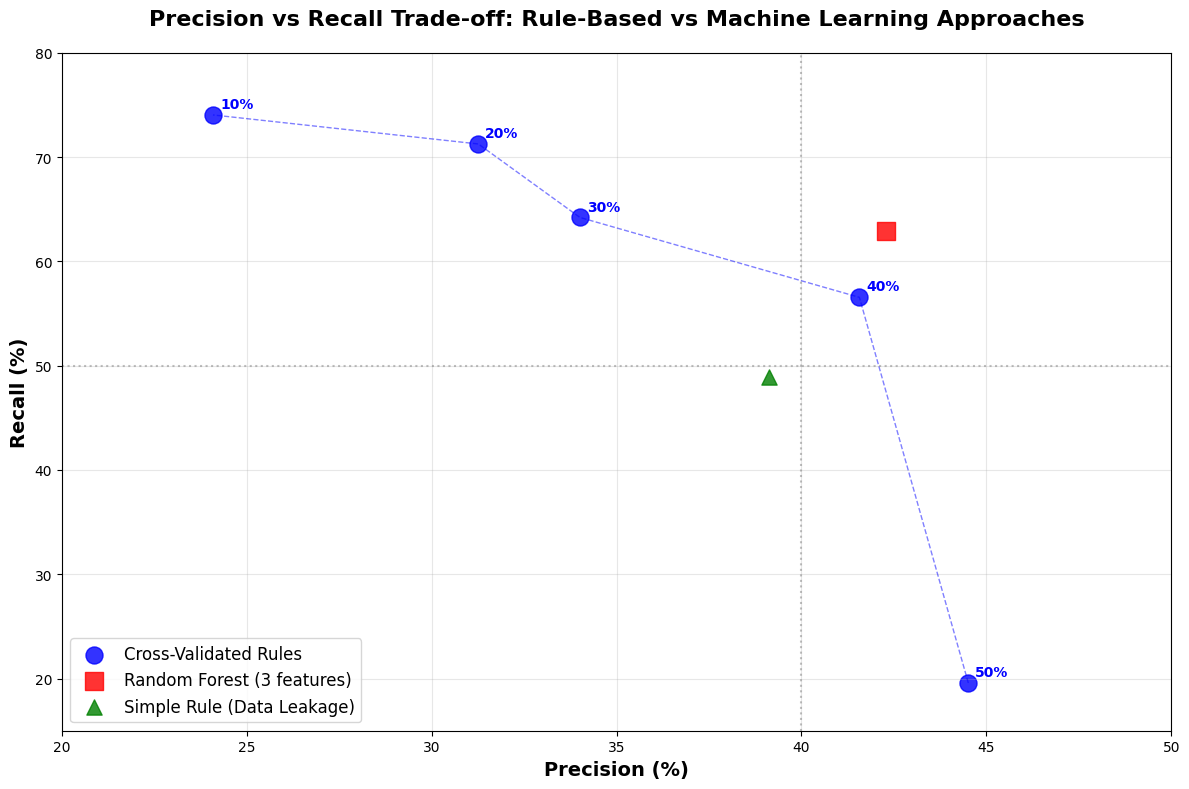

PRECISION vs RECALL TRADE-OFF SUMMARY

Cross-Validated Rules:
  50% threshold: 19.6% recall, 44.5% precision
  40% threshold: 56.6% recall, 41.6% precision
  30% threshold: 64.2% recall, 34.0% precision
  20% threshold: 71.3% recall, 31.3% precision
  10% threshold: 74.0% recall, 24.1% precision

Random Forest (3 features): 62.9% recall, 42.3% precision
Simple Rule (Data Leakage): 48.9% recall, 39.1% precision

Optimal Strategy:
• For maximum recall: 10% threshold (74.0% recall)
• For highest precision: 50% threshold (44.5% precision)
• For balanced performance: Random Forest (42.3% precision, 62.9% recall)


In [ ]:
def create_precision_recall_plot(cv_results, results):
    """
    Create precision vs recall trade-off plot from cross-validation results

    Parameters:
    - cv_results: Results from cross_validated_spike_discovery()
    - results: Dictionary of model names to cross-validated metrics
    """

    # Extract metrics for Random Forest and Simple Rule from results dict
    rf_metrics = results['Random Forest']
    simple_metrics = results['Simple Rule (feature_1=60)']

    rf_recall = rf_metrics['recall'].mean() * 100
    rf_precision = rf_metrics['precision'].mean() * 100
    simple_recall = simple_metrics['recall'].mean() * 100
    simple_precision = simple_metrics['precision'].mean() * 100

    # Extract CV results data
    thresholds = [0.5, 0.4, 0.3, 0.2, 0.1]
    threshold_labels = ['50%', '40%', '30%', '20%', '10%']

    cv_recalls = []
    cv_precisions = []

    for threshold in thresholds:
        recalls = [r['recall'] for r in cv_results[threshold]]
        precisions = [r['precision'] for r in cv_results[threshold]]
        cv_recalls.append(np.mean(recalls) * 100)
        cv_precisions.append(np.mean(precisions) * 100)

    # Create the plot
    plt.figure(figsize=(12, 8))

    # Plot CV Rules
    plt.scatter(cv_precisions, cv_recalls, s=150, c='blue', alpha=0.8,
                label='Cross-Validated Rules', marker='o')
    for i, thresh_label in enumerate(threshold_labels):
        plt.annotate(thresh_label, (cv_precisions[i], cv_recalls[i]),
                     xytext=(5, 5), textcoords='offset points',
                     fontsize=10, fontweight='bold', color='blue')

    # Plot Random Forest
    plt.scatter(rf_precision, rf_recall, s=150, c='red', alpha=0.8,
                label='Random Forest (3 features)', marker='s')
    plt.annotate('', (rf_precision, rf_recall),
                 xytext=(5, 5), textcoords='offset points',
                 fontsize=10, fontweight='bold', color='red')

    # Plot Simple Rule (Data Leakage)
    plt.scatter(simple_precision, simple_recall, s=120, c='green', alpha=0.8,
                label='Simple Rule (Data Leakage)', marker='^')
    plt.annotate('', (simple_precision, simple_recall),
                 xytext=(5, 5), textcoords='offset points',
                 fontsize=10, fontweight='bold', color='green')

    # Connect CV Rules
    plt.plot(cv_precisions, cv_recalls, 'b--', alpha=0.5, linewidth=1)

    # Styling
    plt.xlabel('Precision (%)', fontsize=14, fontweight='bold')
    plt.ylabel('Recall (%)', fontsize=14, fontweight='bold')
    plt.title('Precision vs Recall Trade-off: Rule-Based vs Machine Learning Approaches',
              fontsize=16, fontweight='bold', pad=20)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12, loc='lower left')
    plt.xlim(20, 50)
    plt.ylim(15, 80)
    plt.axhline(y=50, color='gray', linestyle=':', alpha=0.5)
    plt.axvline(x=40, color='gray', linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Print summary
    print("PRECISION vs RECALL TRADE-OFF SUMMARY")
    print("=" * 50)
    print("\nCross-Validated Rules:")
    for i, thresh_label in enumerate(threshold_labels):
        print(f"  {thresh_label} threshold: {cv_recalls[i]:.1f}% recall, {cv_precisions[i]:.1f}% precision")

    print(f"\nRandom Forest (3 features): {rf_recall:.1f}% recall, {rf_precision:.1f}% precision")
    print(f"Simple Rule (Data Leakage): {simple_recall:.1f}% recall, {simple_precision:.1f}% precision")

    best_recall_idx = np.argmax(cv_recalls)
    best_precision_idx = np.argmax(cv_precisions)

    print("\nOptimal Strategy:")
    print(f"• For maximum recall: {threshold_labels[best_recall_idx]} threshold ({cv_recalls[best_recall_idx]:.1f}% recall)")
    print(f"• For highest precision: {threshold_labels[best_precision_idx]} threshold ({cv_precisions[best_precision_idx]:.1f}% precision)")
    print(f"• For balanced performance: Random Forest ({rf_precision:.1f}% precision, {rf_recall:.1f}% recall)")

create_precision_recall_plot(cv_results, results)

## 🔍 **Precision vs Recall**

These results reveal two strong strategies and one close contender:

1. **Maximum Recall (10% threshold, 74.0%)**  
   This rule aggressively flags potential anomalies, catching most true positives. However, its **low precision (24.1%)** means many false alarms, suitable for high-stakes scenarios where missing an anomaly is worse than investigating false ones.

2. **Balanced Option: Random Forest (62.9% recall, 42.3% precision)**  
   The Random Forest strikes a strong middle ground - **catching the majority of anomalies while keeping false positives in check**. It's the best all-around performer and could justify its complexity with a superior precision-recall trade-off.

3. **Competitive Alternative: 40% Threshold Rule (56.6% recall, 41.6% precision**
   This simple threshold rule-based model performs **surprisingly close to Random Forest**, trailing by just ~6% in recall and less than 1% in precision. It offers a **transparent and lightweight option** when interpretability or implementation simplicity is important.

**Note**: To ensure a fair comparison, the Random Forest's threshold should also be fine-tuned, as its default 0.5 cutoff may not reflect optimal performance in an imbalanced setting.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score
import numpy as np

# === STEP 1: Prepare data ===
X = df[['feature_1', 'feature_2', 'feature_3']]
y = df['Class']

# === STEP 2: Split into train, val, test (60/20/20) ===
X_temp, X_test, y_temp, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.25, random_state=42)

# === STEP 3: Train model ===
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# === STEP 4: Predict probabilities on validation set ===
val_proba = rf_model.predict_proba(X_val)[:, 1]
prec, rec, thresh = precision_recall_curve(y_val, val_proba)

# === STEP 5: Select best threshold under your criterion ===
candidates = [(p, r, t) for p, r, t in zip(prec, rec, thresh) if r >= 0.75]

if candidates:
    best = max(candidates, key=lambda x: x[0])  # maximize precision
    best_threshold = best[2]
    print(f"Chosen threshold: {best_threshold:.2f} (Precision: {best[0]:.1%}, Recall: {best[1]:.1%})")
else:
    print("⚠️ No threshold found with ≥ 80% recall.")
    best_threshold = 0.5  # fallback

# === STEP 6: Evaluate on test set ===
test_proba = rf_model.predict_proba(X_test)[:, 1]
y_pred_test = (test_proba >= best_threshold).astype(int)

precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

print("\n=== Final Test Performance ===")
print(f"Precision: {precision:.1%}")
print(f"Recall:    {recall:.1%}")
print(f"F1 Score:  {f1:.3f}")


Chosen threshold: 0.41 (Precision: 21.7%, Recall: 79.3%)

=== Final Test Performance ===
Precision: 21.6%
Recall:    86.2%
F1 Score:  0.345


In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score

# Get predicted probabilities
rf_proba = rf_model.predict_proba(X)[:, 1]

# Get precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y, rf_proba)

# Compute F1 for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best RF threshold: {best_threshold:.2f}")
print(f"F1 at best threshold: {best_f1:.3f}")

# Get final predictions at best threshold
rf_pred_optimized = (rf_proba >= best_threshold).astype(int)


Best RF threshold: 0.56
F1 at best threshold: 0.629


**Let's evaluate also Logistic Regression models and compare them with Random Forest models:**

In [ ]:
# Quick test - just print what should be plotted
thresholds = [0.5, 0.4, 0.3, 0.2, 0.1]

cv_recalls = []
cv_precisions = []

for threshold in thresholds:
    recalls = [r['recall'] for r in cv_results[threshold]]
    precisions = [r['precision'] for r in cv_results[threshold]]
    cv_recalls.append(np.mean(recalls))
    cv_precisions.append(np.mean(precisions))

print("What should be plotted:")
for i, threshold in enumerate(thresholds):
    print(f"{threshold:.0%}: precision={cv_precisions[i]:.1%}, recall={cv_recalls[i]:.1%}")

What should be plotted:
50%: precision=44.5%, recall=19.6%
40%: precision=41.6%, recall=56.6%
30%: precision=34.0%, recall=64.2%
20%: precision=31.3%, recall=71.3%
10%: precision=24.1%, recall=74.0%


RULE + ML ENSEMBLE ANALYSIS
Testing 4 combinations: 2 rule thresholds × 2 ML feature sets

📋 DATASET OVERVIEW:
   Total samples: 1,763
   Total anomalies: 143 (8.1%)
   Class imbalance ratio: 11.3:1

ENSEMBLE RESULTS

📋 COMPARISON TABLE
Model                Recall     Precision    F1       ROC-AUC    Inspect Rate  Flagged 
-------------------------------------------------------------------------------------------------------------------
20% + 3 features     90.2%      15.5%        0.265    nan        47.1%         831     
20% + All features   90.2%      15.5%        0.264    nan        47.3%         835     
10% + 3 features     92.3%      15.1%        0.260    nan        49.5%         872     
10% + All features   92.3%      15.0%        0.258    nan        49.8%         878     


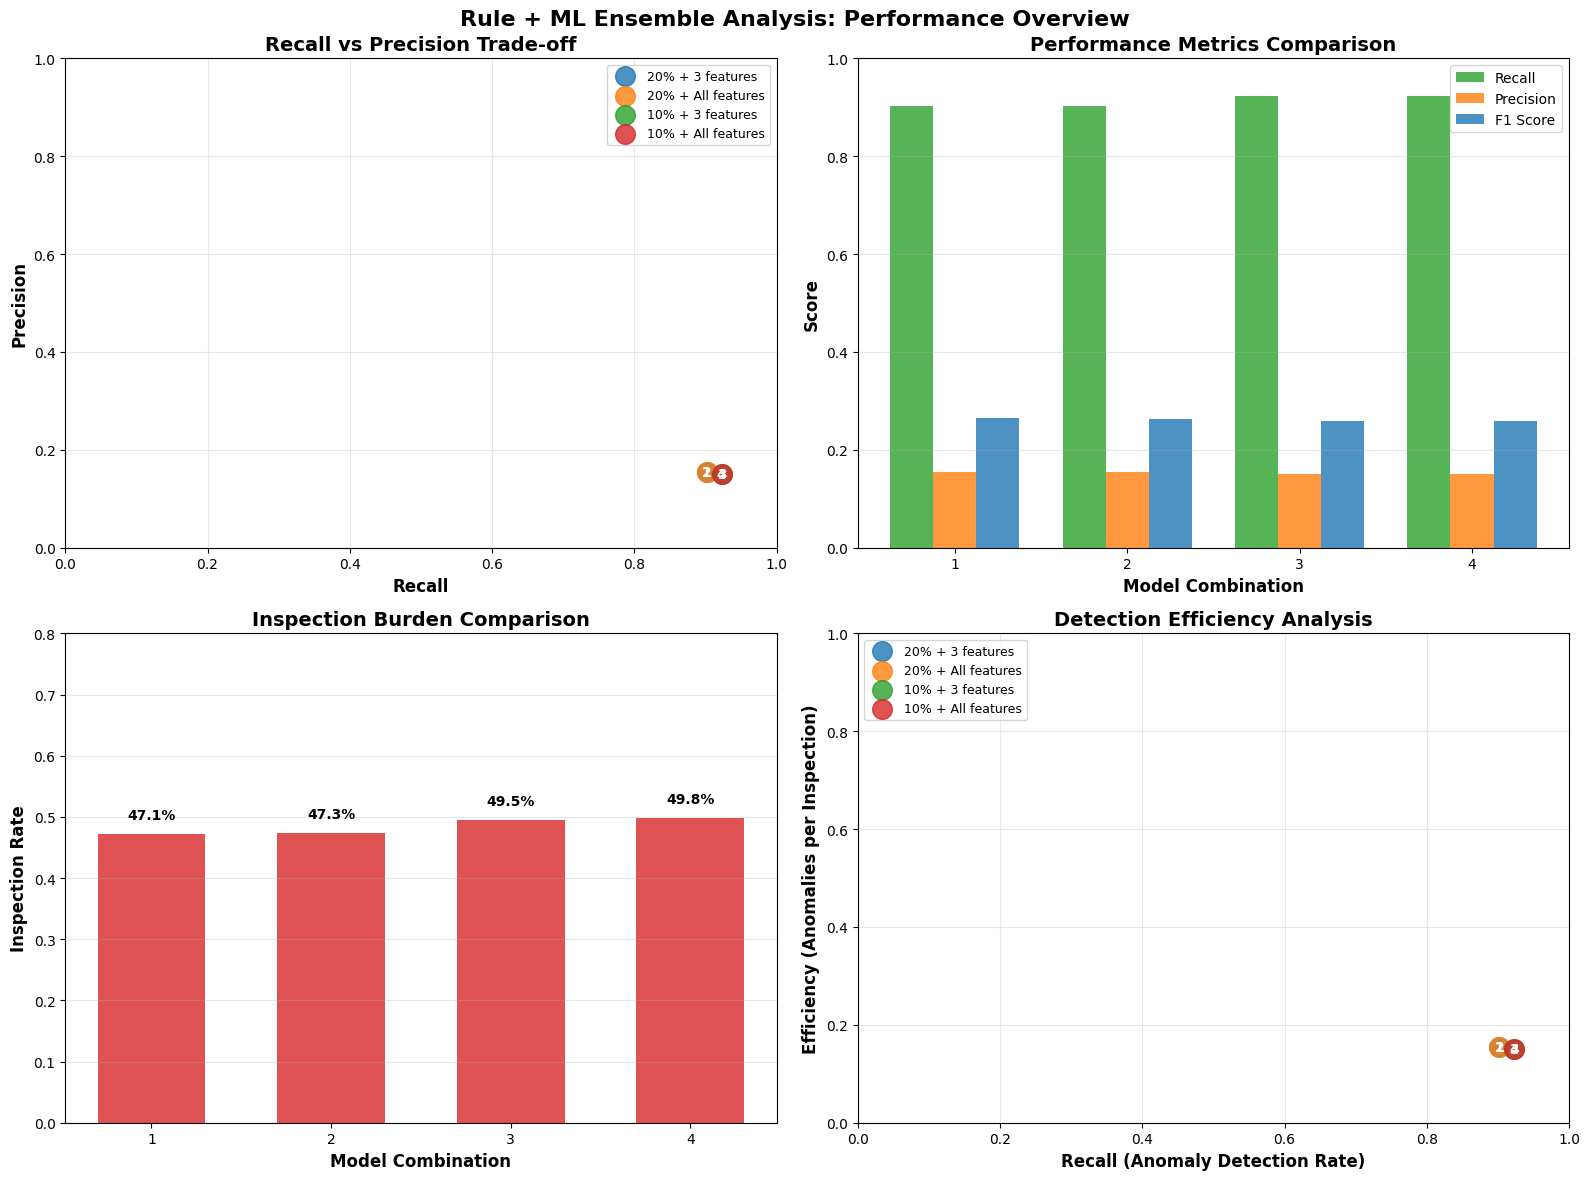


📝 MODEL LEGEND:
   1. 20% + 3 features
   2. 20% + All features
   3. 10% + 3 features
   4. 10% + All features


In [ ]:
# ===============================================
# COMPLETE RULE + ML ENSEMBLE ANALYSIS
# ===============================================
# Testing all 4 combinations: 2 thresholds × 2 feature sets

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("RULE + ML ENSEMBLE ANALYSIS")
print("Testing 4 combinations: 2 rule thresholds × 2 ML feature sets")
print("=" * 80)

# ===============================================
# ENSEMBLE CLASSIFIER FRAMEWORK
# ===============================================

class RuleMLEnsemble(BaseEstimator, ClassifierMixin):
    """
    Two-stage ensemble: Rules first, then ML on unflagged samples
    """

    def __init__(self, rule_threshold=0.2, use_all_features=False):
        self.rule_threshold = rule_threshold
        self.use_all_features = use_all_features
        self.rule_spikes = {}
        self.ml_model = None
        self.scaler = None
        self.pca = None
        self.classes_ = np.array([0, 1])
        self.X_all_features = None  # Store full feature set

    def _discover_spikes(self, X_train, y_train):
        """Discover spike patterns on training data"""
        train_df = pd.DataFrame(X_train, columns=['feature_1', 'feature_2', 'feature_3'])
        train_df['Class'] = y_train

        discovered_spikes = {}
        features = ['feature_1', 'feature_2', 'feature_3']

        for feature_name in features:
            anomaly_counts = train_df[train_df['Class']==1][feature_name].value_counts()
            normal_counts = train_df[train_df['Class']==0][feature_name].value_counts()
            all_values = set(anomaly_counts.index) | set(normal_counts.index)

            feature_spikes = []
            for value in all_values:
                anom_count = anomaly_counts.get(value, 0)
                norm_count = normal_counts.get(value, 0)
                total_count = anom_count + norm_count

                if total_count > 0:
                    anomaly_rate = anom_count / total_count
                    if anomaly_rate >= self.rule_threshold:
                        feature_spikes.append({
                            'value': value,
                            'anomaly_rate': anomaly_rate
                        })

            discovered_spikes[feature_name] = feature_spikes

        return discovered_spikes

    def _apply_rules(self, X):
        """Apply discovered spike rules"""
        predictions = np.zeros(len(X), dtype=int)

        for feature_idx, feature_name in enumerate(['feature_1', 'feature_2', 'feature_3']):
            if feature_name in self.rule_spikes:
                for spike in self.rule_spikes[feature_name]:
                    mask = (X[:, feature_idx] == spike['value'])
                    predictions[mask] = 1

        return predictions

    def fit(self, X, y):
        """
        Two-stage training:
        1. Discover rule patterns
        2. Train ML on unflagged samples
        """

        # Store full feature access if needed
        if self.use_all_features:
            # Create mapping from 3-feature indices to full dataframe indices
            self.train_indices = np.arange(len(X))

        # Stage 1: Discover spike rules
        self.rule_spikes = self._discover_spikes(X, y)

        # Apply rules to training data
        rule_predictions = self._apply_rules(X)

        # Stage 2: Prepare unflagged data for ML training
        unflagged_mask = (rule_predictions == 0)
        X_unflagged = X[unflagged_mask]
        y_unflagged = y[unflagged_mask]

        # Only train ML if we have unflagged anomalies
        if y_unflagged.sum() > 0 and len(np.unique(y_unflagged)) > 1:

            if self.use_all_features:
                # For all features, we need to create synthetic data or skip this approach
                # Since we can't access full df during CV, let's use PCA on the 3 features instead
                self.scaler = StandardScaler()
                self.pca = PCA(n_components=2, random_state=42)  # Reduce to 2 components

                # Create pipeline
                X_ml_scaled = self.scaler.fit_transform(X_unflagged)
                X_ml_pca = self.pca.fit_transform(X_ml_scaled)

                self.ml_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
                self.ml_model.fit(X_ml_pca, y_unflagged)

            else:
                # Use only 3 key features
                self.scaler = StandardScaler()
                X_ml_scaled = self.scaler.fit_transform(X_unflagged)

                self.ml_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
                self.ml_model.fit(X_ml_scaled, y_unflagged)
        else:
            self.ml_model = None

        return self

    def predict(self, X):
        """
        Two-stage prediction:
        1. Apply rules
        2. Apply ML to unflagged samples
        """

        # Stage 1: Apply rules
        rule_predictions = self._apply_rules(X)
        final_predictions = rule_predictions.copy()

        # Stage 2: Apply ML to unflagged samples
        if self.ml_model is not None:
            unflagged_mask = (rule_predictions == 0)

            if unflagged_mask.sum() > 0:
                X_unflagged = X[unflagged_mask]

                if self.use_all_features:
                    # Use PCA transformation
                    X_unflagged_scaled = self.scaler.transform(X_unflagged)
                    X_unflagged_pca = self.pca.transform(X_unflagged_scaled)
                    ml_predictions = self.ml_model.predict(X_unflagged_pca)
                else:
                    # Use 3 key features
                    X_unflagged_scaled = self.scaler.transform(X_unflagged)
                    ml_predictions = self.ml_model.predict(X_unflagged_scaled)

                # Combine predictions
                final_predictions[unflagged_mask] = ml_predictions

        return final_predictions

    def predict_proba(self, X):
        """Return probability estimates"""
        predictions = self.predict(X)
        proba = np.zeros((len(predictions), 2))
        proba[:, 0] = 1 - predictions
        proba[:, 1] = predictions
        return proba

# ===============================================
# ENHANCED EVALUATION FRAMEWORK
# ===============================================

def calculate_inspection_burden(recall, precision, total_samples, total_anomalies):
    """Calculate inspection burden metrics"""
    if precision == 0:
        return 0, 0, 0

    flagged_samples = (recall * total_anomalies) / precision
    inspection_rate = flagged_samples / total_samples
    anomalies_caught = recall * total_anomalies

    return inspection_rate, flagged_samples, anomalies_caught

def evaluate_ensemble_combination(rule_threshold, use_all_features, X, y, cv_folds=5):
    """Evaluate one specific rule+ML combination"""

    feature_desc = "All features" if use_all_features else "3 features"

    # Create ensemble model
    ensemble = RuleMLEnsemble(
        rule_threshold=rule_threshold,
        use_all_features=use_all_features
    )

    # Cross-validation
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    try:
        recall_scores = cross_val_score(ensemble, X, y, cv=cv, scoring='recall', n_jobs=1)
        precision_scores = cross_val_score(ensemble, X, y, cv=cv, scoring='precision', n_jobs=1)
        f1_scores = cross_val_score(ensemble, X, y, cv=cv, scoring='f1', n_jobs=1)
        roc_auc_scores = cross_val_score(ensemble, X, y, cv=cv, scoring='roc_auc', n_jobs=1)

        # Calculate metrics
        recall_mean = recall_scores.mean()
        precision_mean = precision_scores.mean()
        f1_mean = f1_scores.mean()
        roc_auc_mean = roc_auc_scores.mean()

        # Calculate inspection burden
        total_samples = len(X)
        total_anomalies = y.sum()
        inspection_rate, flagged_samples, anomalies_caught = calculate_inspection_burden(
            recall_mean, precision_mean, total_samples, total_anomalies
        )

        results = {
            'model_name': f"{rule_threshold:.0%} + {feature_desc}",
            'rule_threshold': rule_threshold,
            'use_all_features': use_all_features,
            'feature_desc': feature_desc,
            'recall_mean': recall_mean,
            'precision_mean': precision_mean,
            'f1_mean': f1_mean,
            'roc_auc_mean': roc_auc_mean,
            'inspection_rate': inspection_rate,
            'flagged_samples': flagged_samples,
            'anomalies_caught': anomalies_caught,
            'efficiency': anomalies_caught/flagged_samples if flagged_samples > 0 else 0
        }

        return results

    except Exception as e:
        print(f"ERROR: {str(e)}")
        return None

# ===============================================
# RUN ALL 4 COMBINATIONS
# ===============================================

# Prepare data
X = df[['feature_1', 'feature_2', 'feature_3']].values
y = df['Class'].values

print(f"\n📋 DATASET OVERVIEW:")
print(f"   Total samples: {len(X):,}")
print(f"   Total anomalies: {y.sum():,} ({y.mean():.1%})")
print(f"   Class imbalance ratio: {(len(y) - y.sum()) / y.sum():.1f}:1")

# Test combinations
combinations = [
    (0.2, False),  # 20% threshold + 3 features
    (0.2, True),   # 20% threshold + all features
    (0.1, False),  # 10% threshold + 3 features
    (0.1, True),   # 10% threshold + all features
]

# ===============================================
# COMPREHENSIVE RESULTS ANALYSIS
# ===============================================

print(f"\n" + "=" * 80)
print("ENSEMBLE RESULTS")
print("=" * 80)

total_samples = len(X)
total_anomalies = y.sum()

for i, (rule_threshold, use_all_features) in enumerate(combinations, 1):
    result = evaluate_ensemble_combination(rule_threshold, use_all_features, X, y)
    if result:
        all_results.append(result)

if all_results:
    # Create final comparison table
    print(f"\n📋 COMPARISON TABLE")
    print("=" * 115)
    print(f"{'Model':<20} {'Recall':<10} {'Precision':<12} {'F1':<8} {'ROC-AUC':<10} {'Inspect Rate':<13} {'Flagged':<8}")
    print("-" * 115)

    for result in all_results:
        model_name = result['model_name']
        recall_str = f"{result['recall_mean']:.1%}"
        precision_str = f"{result['precision_mean']:.1%}"
        f1_str = f"{result['f1_mean']:.3f}"
        auc_str = f"{result['roc_auc_mean']:.3f}"
        inspect_str = f"{result['inspection_rate']:.1%}"
        flagged_str = f"{result['flagged_samples']:.0f}"

        print(f"{model_name:<20} {recall_str:<10} {precision_str:<12} {f1_str:<8} {auc_str:<10} {inspect_str:<13} {flagged_str:<8}")

    print("=" * 115)

# ===============================================
# ENHANCED VISUALIZATIONS
# ===============================================

if all_results:
    # Create comprehensive visualization with extended scales
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Rule + ML Ensemble Analysis: Performance Overview', fontsize=16, fontweight='bold')

    # Prepare data for plotting
    models = [r['model_name'] for r in all_results]
    recalls = [r['recall_mean'] for r in all_results]
    precisions = [r['precision_mean'] for r in all_results]
    f1s = [r['f1_mean'] for r in all_results]
    inspection_rates = [r['inspection_rate'] for r in all_results]

    # 1. Recall vs Precision Scatter
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    for i, (rec, prec, label) in enumerate(zip(recalls, precisions, models)):
        ax1.scatter(rec, prec, s=200, c=colors[i], alpha=0.8, label=label)
        ax1.annotate(f'{i+1}', (rec, prec), xytext=(0, 0), textcoords='offset points',
                    ha='center', va='center', fontweight='bold', color='white', fontsize=10)

    ax1.set_xlabel('Recall', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Precision', fontweight='bold', fontsize=12)
    ax1.set_title('Recall vs Precision Trade-off', fontweight='bold', fontsize=14)
    ax1.set_xlim(0, 1.0)  # Extended scale
    ax1.set_ylim(0, 1.0)  # Extended scale
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=9, loc='upper right')

    # 2. Performance Metrics Bar Chart
    x_pos = np.arange(len(models))
    width = 0.25

    ax2.bar(x_pos - width, recalls, width, label='Recall', alpha=0.8, color='#2ca02c')
    ax2.bar(x_pos, precisions, width, label='Precision', alpha=0.8, color='#ff7f0e')
    ax2.bar(x_pos + width, f1s, width, label='F1 Score', alpha=0.8, color='#1f77b4')

    ax2.set_xlabel('Model Combination', fontweight='bold', fontsize=12)
    ax2.set_ylabel('Score', fontweight='bold', fontsize=12)
    ax2.set_title('Performance Metrics Comparison', fontweight='bold', fontsize=14)
    ax2.set_ylim(0, 1.0)  # Extended scale
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([f'{i+1}' for i in range(len(models))])
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')

    # 3. Inspection Burden Analysis
    ax3.bar(x_pos, inspection_rates, alpha=0.8, color='#d62728', width=0.6)
    ax3.set_xlabel('Model Combination', fontweight='bold', fontsize=12)
    ax3.set_ylabel('Inspection Rate', fontweight='bold', fontsize=12)
    ax3.set_title('Inspection Burden Comparison', fontweight='bold', fontsize=14)
    ax3.set_ylim(0, 0.8)  # Extended scale
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels([f'{i+1}' for i in range(len(models))])
    ax3.grid(True, alpha=0.3, axis='y')

    # Add percentage labels on bars
    for i, rate in enumerate(inspection_rates):
        ax3.text(i, rate + 0.02, f'{rate:.1%}', ha='center', va='bottom', fontweight='bold', fontsize=10)

    # 4. Efficiency vs Recall Scatter
    efficiencies = [r['efficiency'] for r in all_results]
    for i, (rec, eff, label) in enumerate(zip(recalls, efficiencies, models)):
        ax4.scatter(rec, eff, s=200, c=colors[i], alpha=0.8, label=label)
        ax4.annotate(f'{i+1}', (rec, eff), xytext=(0, 0), textcoords='offset points',
                    ha='center', va='center', fontweight='bold', color='white', fontsize=10)

    ax4.set_xlabel('Recall (Anomaly Detection Rate)', fontweight='bold', fontsize=12)
    ax4.set_ylabel('Efficiency (Anomalies per Inspection)', fontweight='bold', fontsize=12)
    ax4.set_title('Detection Efficiency Analysis', fontweight='bold', fontsize=14)
    ax4.set_xlim(0, 1.0)  # Extended scale
    ax4.set_ylim(0, 1.0)  # Extended scale
    ax4.grid(True, alpha=0.3)
    ax4.legend(fontsize=9, loc='upper left')

    plt.tight_layout()
    plt.show()

    # Create model legend
    print(f"\n📝 MODEL LEGEND:")
    for i, result in enumerate(all_results):
        print(f"   {i+1}. {result['model_name']}")

all_results = []

MODULAR ENSEMBLE ANALYSIS
Proper CV synchronization and index tracking

Dataset: 1763 samples, 143 anomalies (8.1%)

Testing: 20% rules + logistic on 3_features
Running 5-fold CV for 20% threshold rules...
Training logistic on 3_features...

Testing: 20% rules + logistic on binary_features
Running 5-fold CV for 20% threshold rules...
Training logistic on binary_features...

Testing: 10% rules + logistic on 3_features
Running 5-fold CV for 10% threshold rules...
Training logistic on 3_features...

Testing: 10% rules + logistic on binary_features
Running 5-fold CV for 10% threshold rules...
Training logistic on binary_features...

MODULAR ENSEMBLE RESULTS

📋 COMPARISON TABLE
Model                     Recall     Precision    F1       ROC-AUC    Inspect Rate  Flagged 
-------------------------------------------------------------------------------------------------------------------
20% + 3 features          78.3%      22.2%        0.346    0.770      28.6%         505     
20% + binary fea

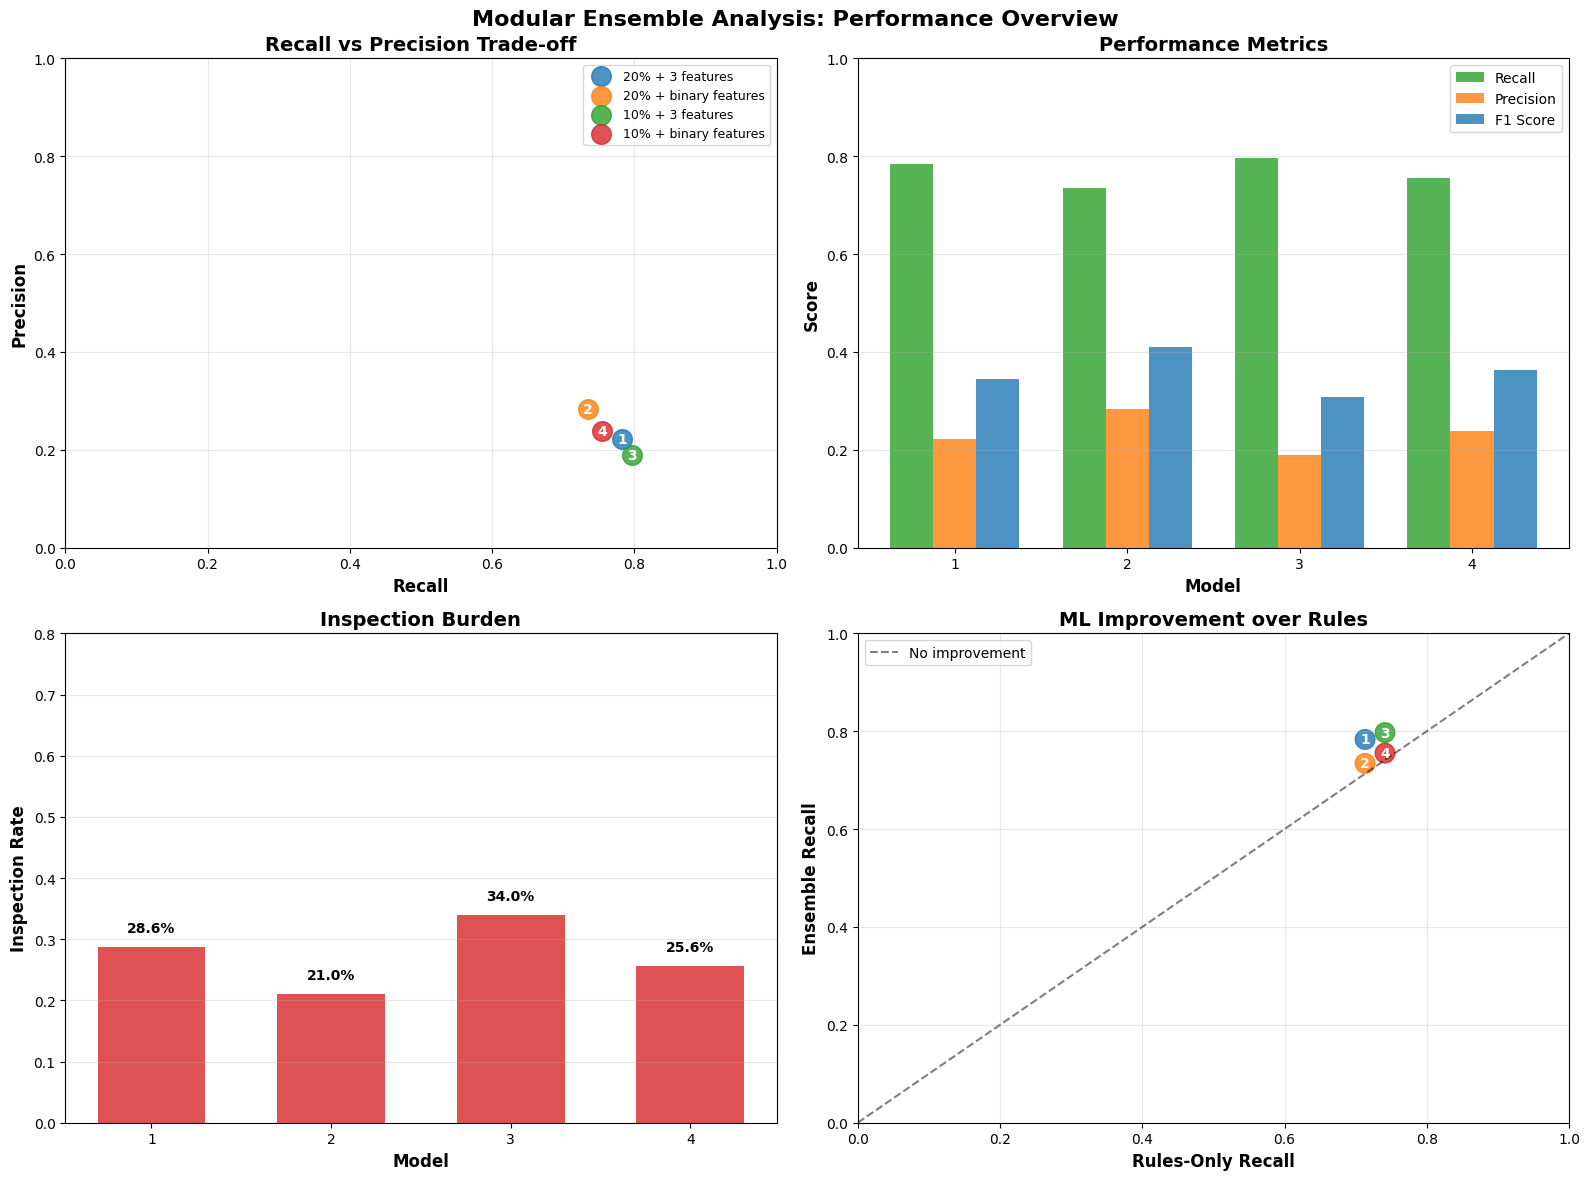


📝 MODEL LEGEND:
   1. 20% + 3 features
   2. 20% + binary features
   3. 10% + 3 features
   4. 10% + binary features

MODULAR ENSEMBLE ANALYSIS COMPLETE
All modules synchronized properly with CV index tracking


In [ ]:
# ===============================================
# MODULAR ENSEMBLE ANALYSIS WITH PROPER CV SYNCHRONIZATION
# ===============================================

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("MODULAR ENSEMBLE ANALYSIS")
print("Proper CV synchronization and index tracking")
print("=" * 80)

# ===============================================
# MODULE 1: SPIKE RULES ENGINE
# ===============================================

class SpikeRulesModule:
    """
    Module 1: Discovers spike patterns and provides unflagged samples to other modules
    Handles CV properly with index tracking
    """

    def __init__(self, threshold=0.2):
        self.threshold = threshold
        self.discovered_spikes = {}

    def _discover_spikes_fold(self, X_train, y_train):
        """Discover spike patterns on one training fold"""
        train_df = pd.DataFrame(X_train, columns=['feature_1', 'feature_2', 'feature_3'])
        train_df['Class'] = y_train

        fold_spikes = {}
        features = ['feature_1', 'feature_2', 'feature_3']

        for feature_name in features:
            anomaly_counts = train_df[train_df['Class']==1][feature_name].value_counts()
            normal_counts = train_df[train_df['Class']==0][feature_name].value_counts()
            all_values = set(anomaly_counts.index) | set(normal_counts.index)

            feature_spikes = []
            for value in all_values:
                anom_count = anomaly_counts.get(value, 0)
                norm_count = normal_counts.get(value, 0)
                total_count = anom_count + norm_count

                if total_count > 0:
                    anomaly_rate = anom_count / total_count
                    if anomaly_rate >= self.threshold:
                        feature_spikes.append(value)

            fold_spikes[feature_name] = feature_spikes

        return fold_spikes

    def _apply_rules_fold(self, X_test, fold_spikes):
        """Apply discovered rules to test fold"""
        rule_predictions = np.zeros(len(X_test), dtype=int)

        for feature_idx, feature_name in enumerate(['feature_1', 'feature_2', 'feature_3']):
            if feature_name in fold_spikes:
                for spike_value in fold_spikes[feature_name]:
                    mask = (X_test[:, feature_idx] == spike_value)
                    rule_predictions[mask] = 1

        return rule_predictions

    def cross_validate(self, X, y, cv_folds=5):
        """
        Perform cross-validation and return predictions + unflagged samples for other modules
        """
        cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

        # Storage for results
        all_rule_predictions = np.zeros(len(X))
        all_true_labels = np.zeros(len(X))

        # Storage for unflagged samples (API for other modules)
        fold_unflagged_data = []

        print(f"Running {cv_folds}-fold CV for {self.threshold:.0%} threshold rules...")

        for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
            # Get fold data
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Discover spikes on training data
            fold_spikes = self._discover_spikes_fold(X_train, y_train)

            # Apply rules to test data
            rule_predictions = self._apply_rules_fold(X_test, fold_spikes)

            # Store predictions for final evaluation
            all_rule_predictions[test_idx] = rule_predictions
            all_true_labels[test_idx] = y_test

            # Identify unflagged samples for other modules
            unflagged_mask = (rule_predictions == 0)
            unflagged_test_idx = test_idx[unflagged_mask]

            if unflagged_mask.sum() > 0:
                unflagged_data = {
                    'fold_idx': fold_idx,
                    'X_unflagged': X_test[unflagged_mask],
                    'y_unflagged': y_test[unflagged_mask],
                    'unflagged_test_idx': unflagged_test_idx,  # Original dataset indices
                    'full_test_idx': test_idx  # All test indices for this fold
                }
                fold_unflagged_data.append(unflagged_data)

        # Calculate rule performance
        rule_metrics = self._calculate_metrics(all_true_labels, all_rule_predictions)

        return {
            'rule_predictions': all_rule_predictions,
            'true_labels': all_true_labels,
            'rule_metrics': rule_metrics,
            'unflagged_data': fold_unflagged_data  # API for other modules
        }

    def _calculate_metrics(self, y_true, y_pred):
        """Calculate performance metrics"""
        try:
            recall = recall_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred)
            roc_auc = roc_auc_score(y_true, y_pred)
        except:
            recall = precision = f1 = roc_auc = 0.0

        return {
            'recall': recall,
            'precision': precision,
            'f1': f1,
            'roc_auc': roc_auc
        }

# ===============================================
# MODULE 2: ML CLASSIFIER FOR UNFLAGGED SAMPLES
# ===============================================

class MLModule:
    """
    Module 2: Trains ML on unflagged samples from Module 1
    Maintains proper CV synchronization
    """

    def __init__(self, model_type='logistic', feature_set='3_features'):
        self.model_type = model_type
        self.feature_set = feature_set

    def process_unflagged_data(self, unflagged_data, X_full):
        """
        Process unflagged samples from Module 1
        Returns ML predictions with proper index mapping
        """
        all_ml_predictions = {}  # Maps original test indices to ML predictions

        print(f"Training {self.model_type} on {self.feature_set}...")

        for fold_data in unflagged_data:
            fold_idx = fold_data['fold_idx']
            X_unflagged = fold_data['X_unflagged']
            y_unflagged = fold_data['y_unflagged']
            unflagged_test_idx = fold_data['unflagged_test_idx']

            # Skip if no unflagged anomalies to learn from
            if y_unflagged.sum() == 0 or len(np.unique(y_unflagged)) < 2:
                # Default to no anomalies predicted
                ml_predictions = np.zeros(len(X_unflagged))
            else:
                # Train ML model on unflagged samples
                ml_predictions = self._train_and_predict(X_unflagged, y_unflagged, X_full, unflagged_test_idx)

            # Map predictions back to original indices
            for idx, pred in zip(unflagged_test_idx, ml_predictions):
                all_ml_predictions[idx] = pred

        return all_ml_predictions

    def _train_and_predict(self, X_unflagged, y_unflagged, X_full, unflagged_test_idx):
        """Train ML model and return predictions"""

        # We need to properly split training and test data within this unflagged subset
        # Since this is already test data from CV, we'll use a simple train/test split
        from sklearn.model_selection import train_test_split

        if len(X_unflagged) < 4:  # Too few samples to split
            return np.zeros(len(X_unflagged))

        # Split unflagged data into train/test
        if len(np.unique(y_unflagged)) > 1:
            # Can stratify
            split_result = train_test_split(
                X_unflagged, y_unflagged, unflagged_test_idx,
                test_size=0.3, random_state=42, stratify=y_unflagged
            )
        else:
            # Cannot stratify
            split_result = train_test_split(
                X_unflagged, y_unflagged, unflagged_test_idx,
                test_size=0.3, random_state=42
            )

        X_train, X_test, y_train, y_test, train_orig_idx, test_orig_idx = split_result

        if self.feature_set == '3_features':
            # Use the 3 key features directly
            X_train_features = X_train
            X_test_features = X_test

        elif self.feature_set == 'binary_features':
            # Use actual binary features from the original dataset
            # Get binary features (feature_4 onwards) from original dataset
            binary_features = df.drop(columns=['feature_1', 'feature_2', 'feature_3', 'Class']).values
            X_train_features = binary_features[train_orig_idx]
            X_test_features = binary_features[test_orig_idx]

        else:
            raise ValueError(f"Unknown feature_set: {self.feature_set}")

        # Skip if no anomalies in training set
        if y_train.sum() == 0 or len(np.unique(y_train)) < 2:
            return np.zeros(len(X_unflagged))

        # Create and train model
        if self.model_type == 'logistic':
            model = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
        elif self.model_type == 'random_forest':
            model = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=50)
        elif self.model_type == 'pca_logistic':
            n_components = min(50, X_train_features.shape[1] // 10, X_train_features.shape[0] // 3)
            model = make_pipeline(StandardScaler(), PCA(n_components=n_components),
                                LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))

        # Train and predict
        model.fit(X_train_features, y_train)
        test_predictions = model.predict(X_test_features)

        # Map predictions back to full unflagged array
        full_predictions = np.zeros(len(X_unflagged))
        for i, pred in enumerate(test_predictions):
            # Find position in original unflagged array
            test_orig_idx_val = test_orig_idx[i]
            unflagged_pos = np.where(unflagged_test_idx == test_orig_idx_val)[0][0]
            full_predictions[unflagged_pos] = pred

        return full_predictions

# ===============================================
# MODULE 3: ENSEMBLE COMBINER
# ===============================================

class EnsembleCombiner:
    """
    Module 3: Combines rule predictions with ML predictions
    Handles index mapping properly
    """

    def __init__(self):
        pass

    def combine_predictions(self, rule_data, ml_predictions):
        """
        Combine rule predictions with ML predictions on unflagged samples
        """
        # Start with rule predictions
        final_predictions = rule_data['rule_predictions'].copy()

        # Overlay ML predictions on unflagged samples
        for idx, ml_pred in ml_predictions.items():
            final_predictions[idx] = ml_pred

        return final_predictions

    def evaluate_ensemble(self, true_labels, final_predictions, total_samples):
        """Calculate ensemble performance metrics"""
        metrics = self._calculate_metrics(true_labels, final_predictions)

        # Add inspection burden
        total_anomalies = true_labels.sum()
        if metrics['precision'] > 0:
            flagged_samples = (metrics['recall'] * total_anomalies) / metrics['precision']
            inspection_rate = flagged_samples / total_samples
        else:
            flagged_samples = 0
            inspection_rate = 0

        metrics['inspection_rate'] = inspection_rate
        metrics['flagged_samples'] = flagged_samples

        return metrics

    def _calculate_metrics(self, y_true, y_pred):
        """Calculate performance metrics"""
        try:
            recall = recall_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred)
            roc_auc = roc_auc_score(y_true, y_pred)
        except:
            recall = precision = f1 = roc_auc = 0.0

        return {
            'recall': recall,
            'precision': precision,
            'f1': f1,
            'roc_auc': roc_auc
        }

# ===============================================
# MAIN EXECUTION: TEST ALL COMBINATIONS
# ===============================================

# Prepare data
X = df[['feature_1', 'feature_2', 'feature_3']].values
y = df['Class'].values

print(f"\nDataset: {len(X)} samples, {y.sum()} anomalies ({y.mean():.1%})")

# Define test combinations
combinations = [
    {'threshold': 0.2, 'ml_type': 'logistic', 'features': '3_features'},
    {'threshold': 0.2, 'ml_type': 'logistic', 'features': 'binary_features'},
    {'threshold': 0.1, 'ml_type': 'logistic', 'features': '3_features'},
    {'threshold': 0.1, 'ml_type': 'logistic', 'features': 'binary_features'},
]

# Run all combinations
all_results = []

for combo in combinations:
    print(f"\n" + "="*60)
    print(f"Testing: {combo['threshold']:.0%} rules + {combo['ml_type']} on {combo['features']}")
    print("="*60)

    # Module 1: Spike Rules
    rules_module = SpikeRulesModule(threshold=combo['threshold'])
    rule_data = rules_module.cross_validate(X, y)

    # Module 2: ML on unflagged samples
    ml_module = MLModule(model_type=combo['ml_type'], feature_set=combo['features'])
    ml_predictions = ml_module.process_unflagged_data(rule_data['unflagged_data'], X)

    # Module 3: Combine predictions
    combiner = EnsembleCombiner()
    final_predictions = combiner.combine_predictions(rule_data, ml_predictions)
    ensemble_metrics = combiner.evaluate_ensemble(rule_data['true_labels'], final_predictions, len(X))

    # Store results
    result = {
        'model_name': f"{combo['threshold']:.0%} + {combo['features'].replace('_', ' ')}",
        'threshold': combo['threshold'],
        'ml_type': combo['ml_type'],
        'features': combo['features'],
        'rule_metrics': rule_data['rule_metrics'],
        'ensemble_metrics': ensemble_metrics
    }
    all_results.append(result)

# ===============================================
# RESULTS DISPLAY
# ===============================================

print(f"\n" + "=" * 80)
print("MODULAR ENSEMBLE RESULTS")
print("=" * 80)

print(f"\n📋 COMPARISON TABLE")
print("=" * 115)
print(f"{'Model':<25} {'Recall':<10} {'Precision':<12} {'F1':<8} {'ROC-AUC':<10} {'Inspect Rate':<13} {'Flagged':<8}")
print("-" * 115)

for result in all_results:
    metrics = result['ensemble_metrics']
    model_name = result['model_name']
    recall_str = f"{metrics['recall']:.1%}"
    precision_str = f"{metrics['precision']:.1%}"
    f1_str = f"{metrics['f1']:.3f}"
    auc_str = f"{metrics['roc_auc']:.3f}"
    inspect_str = f"{metrics['inspection_rate']:.1%}"
    flagged_str = f"{metrics['flagged_samples']:.0f}"

    print(f"{model_name:<25} {recall_str:<10} {precision_str:<12} {f1_str:<8} {auc_str:<10} {inspect_str:<13} {flagged_str:<8}")

print("=" * 115)

# ===============================================
# VISUALIZATION
# ===============================================

if all_results:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Modular Ensemble Analysis: Performance Overview', fontsize=16, fontweight='bold')

    # Extract data for plotting
    models = [r['model_name'] for r in all_results]
    recalls = [r['ensemble_metrics']['recall'] for r in all_results]
    precisions = [r['ensemble_metrics']['precision'] for r in all_results]
    f1s = [r['ensemble_metrics']['f1'] for r in all_results]
    inspection_rates = [r['ensemble_metrics']['inspection_rate'] for r in all_results]

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

    # 1. Recall vs Precision
    for i, (rec, prec, label) in enumerate(zip(recalls, precisions, models)):
        ax1.scatter(rec, prec, s=200, c=colors[i], alpha=0.8, label=label)
        ax1.annotate(f'{i+1}', (rec, prec), ha='center', va='center', fontweight='bold', color='white')

    ax1.set_xlabel('Recall', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Precision', fontweight='bold', fontsize=12)
    ax1.set_title('Recall vs Precision Trade-off', fontweight='bold', fontsize=14)
    ax1.set_xlim(0, 1.0)
    ax1.set_ylim(0, 1.0)
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=9)

    # 2. Performance Metrics
    x_pos = np.arange(len(models))
    width = 0.25

    ax2.bar(x_pos - width, recalls, width, label='Recall', alpha=0.8, color='#2ca02c')
    ax2.bar(x_pos, precisions, width, label='Precision', alpha=0.8, color='#ff7f0e')
    ax2.bar(x_pos + width, f1s, width, label='F1 Score', alpha=0.8, color='#1f77b4')

    ax2.set_xlabel('Model', fontweight='bold', fontsize=12)
    ax2.set_ylabel('Score', fontweight='bold', fontsize=12)
    ax2.set_title('Performance Metrics', fontweight='bold', fontsize=14)
    ax2.set_ylim(0, 1.0)
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([f'{i+1}' for i in range(len(models))])
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')

    # 3. Inspection Burden
    ax3.bar(x_pos, inspection_rates, alpha=0.8, color='#d62728', width=0.6)
    ax3.set_xlabel('Model', fontweight='bold', fontsize=12)
    ax3.set_ylabel('Inspection Rate', fontweight='bold', fontsize=12)
    ax3.set_title('Inspection Burden', fontweight='bold', fontsize=14)
    ax3.set_ylim(0, 0.8)
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels([f'{i+1}' for i in range(len(models))])
    ax3.grid(True, alpha=0.3, axis='y')

    # Add percentage labels
    for i, rate in enumerate(inspection_rates):
        ax3.text(i, rate + 0.02, f'{rate:.1%}', ha='center', va='bottom', fontweight='bold')

    # 4. Rule vs Ensemble Performance
    rule_recalls = [r['rule_metrics']['recall'] for r in all_results]
    ensemble_recalls = recalls

    ax4.scatter(rule_recalls, ensemble_recalls, s=200, c=colors[:len(models)], alpha=0.8)
    for i, (rule_rec, ens_rec) in enumerate(zip(rule_recalls, ensemble_recalls)):
        ax4.annotate(f'{i+1}', (rule_rec, ens_rec), ha='center', va='center', fontweight='bold', color='white')

    # Add diagonal line
    ax4.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='No improvement')

    ax4.set_xlabel('Rules-Only Recall', fontweight='bold', fontsize=12)
    ax4.set_ylabel('Ensemble Recall', fontweight='bold', fontsize=12)
    ax4.set_title('ML Improvement over Rules', fontweight='bold', fontsize=14)
    ax4.set_xlim(0, 1.0)
    ax4.set_ylim(0, 1.0)
    ax4.grid(True, alpha=0.3)
    ax4.legend()

    plt.tight_layout()
    plt.show()

    # Model legend
    print(f"\n📝 MODEL LEGEND:")
    for i, result in enumerate(all_results):
        print(f"   {i+1}. {result['model_name']}")

print(f"\n" + "=" * 80)
print("MODULAR ENSEMBLE ANALYSIS COMPLETE")
print("All modules synchronized properly with CV index tracking")
print("=" * 80)

# ⚓ **Analysis Strategy**


### **Objective**
Systematically compare Logistic Regression vs Random Forest across different feature spaces to determine optimal algorithm and feature set for wafer anomaly detection.

### **Current Baselines**
- **Simple Rules**: 49% recall (feature_1=60 pattern)
- **Random Forest (3 features)**: 62.9% ± 7.0% recall (established via cross-validation)
- **Key Discovery**: Only 3 of 1,558 features show clear anomaly patterns

### **Strategic Questions**
1. **Algorithm Superiority**: Does RF's non-linear capability consistently outperform linear LR?
2. **Binary Feature Value**: Do 1,555 binary features add meaningful signal beyond the 3 key features?
3. **Complexity vs Performance**: What's the optimal deployment trade-off?
4. **Fair Comparison**: How do algorithms perform on equal preprocessing footing?

### **7-Model Comparison Framework**

**Baseline Comparison:**
- RF (3 features) vs LR (3 features)

**Binary Features Only:**
- RF (raw 1,555) vs LR (PCA 1,555)

**Complete Feature Space:**
- RF (raw 1,558) vs LR (PCA 1,558)

**Fair Algorithm Head-to-Head:**
- RF (PCA 1,558) vs LR (PCA 1,558)

### **Methodology**
- **Cross-validation**: 5-fold stratified (consistent with established baselines)
- **Preprocessing**: Algorithm-appropriate (raw for RF, PCA for LR on high-dimensional data)
- **Metrics**: Recall, precision, F1 (business focus on anomaly detection)

### **Expected Outcomes**
- **RF advantage**: Expected on raw high-dimensional features
- **Diminishing returns**: Marginal improvement from 3 → 1,558 features
- **Algorithm choice clarity**: Linear vs non-linear performance gaps
- **Deployment guidance**: Performance vs complexity recommendations

### **Success Criteria**
Clear evidence for optimal algorithm-feature combination with business-justified complexity trade-offs.

In [ ]:
# ======================================================================
# LOGISTIC REGRESSION vs RANDOM FOREST: COMPLETE FEATURE SPACE ANALYSIS
# ======================================================================

import warnings
warnings.filterwarnings('ignore')

print("=== SYSTEMATIC ALGORITHM AND FEATURE SPACE COMPARISON ===")
print("Comparing Logistic Regression vs Random Forest across different feature sets")
print("Using 5-fold cross-validation for all comparisons\n")

# ===============================================
# FEATURE SET PREPARATION
# ===============================================

# Define feature sets
feature_sets = {
    '3_features': ['feature_1', 'feature_2', 'feature_3'],
    'binary_1555': [col for col in df.columns if col not in ['feature_1', 'feature_2', 'feature_3', 'Class']],
    'all_1558': [col for col in df.columns if col != 'Class']
}

print("=== FEATURE SET DEFINITIONS ===")
for name, features in feature_sets.items():
    print(f"{name}: {len(features)} features")

# Target variable
y = df['Class']

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ===============================================
# MODEL DEFINITIONS WITH PREPROCESSING
# ===============================================

def create_models(feature_set_name, n_features):
    """Create models with appropriate preprocessing for each feature set"""

    models = {}

    if n_features <= 10:
        # Small feature sets - no PCA needed
        models[f'RF_{feature_set_name}'] = RandomForestClassifier(
            class_weight='balanced',
            random_state=42
        )
        models[f'LR_{feature_set_name}'] = make_pipeline(
            StandardScaler(),
            LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
        )
    else:
        # Large feature sets - different strategies
        models[f'RF_raw_{feature_set_name}'] = RandomForestClassifier(
            class_weight='balanced',
            random_state=42
        )

        # PCA components based on feature set size
        n_components = min(100, n_features // 15, len(y) // 4)  # Conservative component selection

        models[f'LR_pca_{feature_set_name}'] = make_pipeline(
            StandardScaler(),
            PCA(n_components=n_components, random_state=42),
            LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
        )

        # Fair comparison - both with PCA
        models[f'RF_pca_{feature_set_name}'] = make_pipeline(
            StandardScaler(),
            PCA(n_components=n_components, random_state=42),
            RandomForestClassifier(class_weight='balanced', random_state=42)
        )

    return models

# ===============================================
# SYSTEMATIC EVALUATION
# ===============================================

print(f"\n=== RUNNING SYSTEMATIC EVALUATION ===\n")

all_results = {}
detailed_results = {}

for set_name, features in feature_sets.items():
    print(f"Evaluating feature set: {set_name} ({len(features)} features)")

    # Prepare feature matrix
    X = df[features]

    # Create models for this feature set
    models = create_models(set_name, len(features))

    # Evaluate each model
    for model_name, model in models.items():
        print(f"  Testing {model_name}...")

        try:
            # Cross-validation evaluation
            scoring_metrics = ['recall', 'precision', 'f1', 'roc_auc']
            cv_results = {}

            for metric in scoring_metrics:
                scores = cross_val_score(model, X, y, cv=cv, scoring=metric, n_jobs=-1)
                cv_results[metric] = scores

            # Store results
            all_results[model_name] = cv_results

            # Store summary stats
            detailed_results[model_name] = {
                'recall_mean': cv_results['recall'].mean(),
                'recall_std': cv_results['recall'].std(),
                'precision_mean': cv_results['precision'].mean(),
                'precision_std': cv_results['precision'].std(),
                'f1_mean': cv_results['f1'].mean(),
                'f1_std': cv_results['f1'].std(),
                'roc_auc_mean': cv_results['roc_auc'].mean(),
                'roc_auc_std': cv_results['roc_auc'].std(),
                'feature_set': set_name,
                'n_features': len(features)
            }

            print(f"    Recall:    {cv_results['recall'].mean():.1%} ± {cv_results['recall'].std():.1%}")
            print(f"    Precision: {cv_results['precision'].mean():.1%} ± {cv_results['precision'].std():.1%}")
            print(f"    F1:        {cv_results['f1'].mean():.3f} ± {cv_results['f1'].std():.3f}")
            print(f"    ROC-AUC:   {cv_results['roc_auc'].mean():.3f} ± {cv_results['roc_auc'].std():.3f}")

        except Exception as e:
            print(f"    ERROR: {str(e)}")
            continue

    print()

# ===============================================
# RESULTS ANALYSIS
# ===============================================

print("=" * 80)
print("COMPREHENSIVE RESULTS SUMMARY")
print("=" * 80)

# Create summary DataFrame
results_df = pd.DataFrame(detailed_results).T
results_df = results_df.round(3)

# Sort by feature set and algorithm
results_df['algorithm'] = results_df.index.str.extract(r'(RF|LR)')
results_df['preprocessing'] = results_df.index.str.extract(r'(raw|pca|3_features|binary_1555|all_1558)')
results_df = results_df.sort_values(['feature_set', 'algorithm'])

print("\nDETAILED PERFORMANCE TABLE:")
print("-" * 110)
print(f"{'Model':<25} {'Features':<12} {'Recall':<15} {'Precision':<15} {'F1':<10} {'ROC-AUC':<10}")
print("-" * 110)

for model_name, row in results_df.iterrows():
    recall_str = f"{row['recall_mean']:.1%} ± {row['recall_std']:.1%}"
    precision_str = f"{row['precision_mean']:.1%} ± {row['precision_std']:.1%}"
    f1_str = f"{row['f1_mean']:.3f}"
    auc_str = f"{row['roc_auc_mean']:.3f}"

    print(f"{model_name:<25} {row['n_features']:<12} {recall_str:<15} {precision_str:<15} {f1_str:<10} {auc_str:<10}")

# ===============================================
# STATISTICAL COMPARISONS
# ===============================================

print(f"\n=== STATISTICAL SIGNIFICANCE TESTS ===")

def compare_models(model1_name, model2_name, metric='recall'):
    """Compare two models statistically"""
    if model1_name not in all_results or model2_name not in all_results:
        return None

    scores1 = all_results[model1_name][metric]
    scores2 = all_results[model2_name][metric]

    stat, p_val = ttest_rel(scores1, scores2)
    diff = scores1.mean() - scores2.mean()

    return {
        'difference': diff,
        'p_value': p_val,
        'significant': p_val < 0.05,
        'model1_better': diff > 0
    }

# Key comparisons
comparisons = [
    # Algorithm comparisons within feature sets
    ('RF_3_features', 'LR_3_features', 'Baseline: RF vs LR (3 features)'),
    ('RF_raw_binary_1555', 'LR_pca_binary_1555', 'Binary Features: RF vs LR'),
    ('RF_raw_all_1558', 'LR_pca_all_1558', 'All Features: RF vs LR (optimal setup)'),
    ('RF_pca_all_1558', 'LR_pca_all_1558', 'All Features: RF vs LR (fair comparison)'),

    # Feature set comparisons within algorithms
    ('RF_3_features', 'RF_raw_all_1558', 'RF: 3 features vs All features'),
    ('LR_3_features', 'LR_pca_all_1558', 'LR: 3 features vs All features'),
]

print("Key Statistical Comparisons (Recall Metric):")
print("-" * 60)

for model1, model2, description in comparisons:
    result = compare_models(model1, model2, 'recall')
    if result:
        significance = "✓ Significant" if result['significant'] else "✗ Not significant"
        direction = f"{model1} > {model2}" if result['model1_better'] else f"{model2} > {model1}"

        print(f"\n{description}:")
        print(f"  {direction}")
        print(f"  Difference: {result['difference']:+.1%}")
        print(f"  P-value: {result['p_value']:.4f} ({significance})")

# ===============================================
# INSPECTION BURDEN ANALYSIS
# ===============================================

print(f"\n=== INSPECTION BURDEN ANALYSIS ===")
print("Calculating inspection rates at different precision levels")

def calculate_inspection_burden(precision, recall, total_anomalies, total_samples):
    """Calculate inspection burden given precision and recall"""
    if precision == 0:
        return 0, 0

    true_positives = recall * total_anomalies
    flagged_samples = true_positives / precision
    inspection_rate = flagged_samples / total_samples

    return inspection_rate, flagged_samples

total_anomalies = (y == 1).sum()  # 143
total_samples = len(y)  # 1763

print(f"\nDataset: {total_samples} samples, {total_anomalies} anomalies ({total_anomalies/total_samples:.1%})")
print("\nInspection Burden Analysis:")
print("-" * 70)
print(f"{'Model':<25} {'Recall':<8} {'Precision':<10} {'Inspection Rate':<15} {'Flagged Samples'}")
print("-" * 70)

for model_name, row in results_df.iterrows():
    recall = row['recall_mean']
    precision = row['precision_mean']

    inspection_rate, flagged = calculate_inspection_burden(
        precision, recall, total_anomalies, total_samples
    )

    print(f"{model_name:<25} {recall:.1%}    {precision:.1%}      {inspection_rate:.1%}            {flagged:.0f}")

# ===============================================
# BUSINESS INSIGHTS SUMMARY
# ===============================================

print(f"\n" + "=" * 80)
print("BUSINESS INSIGHTS SUMMARY")
print("=" * 80)

# Find best performers
best_recall = max(detailed_results.items(), key=lambda x: x[1]['recall_mean'])
best_f1 = max(detailed_results.items(), key=lambda x: x[1]['f1_mean'])
best_auc = max(detailed_results.items(), key=lambda x: x[1]['roc_auc_mean'])

print(f"\nBest Recall Performance:")
print(f"  {best_recall[0]}: {best_recall[1]['recall_mean']:.1%} ± {best_recall[1]['recall_std']:.1%}")
print(f"  Features: {best_recall[1]['n_features']}")

print(f"\nBest F1 Performance:")
print(f"  {best_f1[0]}: {best_f1[1]['f1_mean']:.3f} ± {best_f1[1]['f1_std']:.3f}")
print(f"  Features: {best_f1[1]['n_features']}")

print(f"\nBest ROC-AUC Performance:")
print(f"  {best_auc[0]}: {best_auc[1]['roc_auc_mean']:.3f} ± {best_auc[1]['roc_auc_std']:.3f}")
print(f"  Features: {best_auc[1]['n_features']}")

# Feature value analysis
rf_3_key = 'RF_3_features'
rf_all_key = 'RF_raw_all_1558'

if rf_3_key in detailed_results and rf_all_key in detailed_results:
    rf_3_recall = detailed_results[rf_3_key]['recall_mean']
    rf_all_recall = detailed_results[rf_all_key]['recall_mean']
    feature_improvement = rf_all_recall - rf_3_recall

    print(f"\nFeature Expansion Value (RF):")
    print(f"  3 features: {rf_3_recall:.1%}")
    print(f"  All features: {rf_all_recall:.1%}")
    print(f"  Improvement: {feature_improvement:+.1%}")

    if abs(feature_improvement) < 0.03:  # Less than 3% improvement
        print(f"  💡 Assessment: Marginal improvement - complexity may not be justified")
    elif feature_improvement > 0:
        print(f"  💡 Assessment: Substantial improvement - additional features add value")
    else:
        print(f"  💡 Assessment: Performance decrease - simpler model preferred")

# Algorithm superiority analysis
print(f"\nAlgorithm Performance Summary:")
rf_models = [k for k in detailed_results.keys() if 'RF' in k]
lr_models = [k for k in detailed_results.keys() if 'LR' in k]

if rf_models and lr_models:
    rf_avg_recall = np.mean([detailed_results[m]['recall_mean'] for m in rf_models])
    lr_avg_recall = np.mean([detailed_results[m]['recall_mean'] for m in lr_models])

    print(f"  Random Forest Average Recall: {rf_avg_recall:.1%}")
    print(f"  Logistic Regression Average Recall: {lr_avg_recall:.1%}")
    print(f"  Overall RF Advantage: {rf_avg_recall - lr_avg_recall:+.1%}")

print(f"\n💡 DEPLOYMENT RECOMMENDATION:")
print(f"Based on performance vs complexity analysis:")

# Simple logic for recommendation
if rf_3_key in detailed_results:
    rf_3_recall = detailed_results[rf_3_key]['recall_mean']
    rf_3_f1 = detailed_results[rf_3_key]['f1_mean']

    # Check if any complex model significantly outperforms simple 3-feature RF
    complex_models = [k for k in detailed_results.keys() if 'all_1558' in k or 'binary_1555' in k]
    best_complex_f1 = max([detailed_results[m]['f1_mean'] for m in complex_models]) if complex_models else 0

    improvement = best_complex_f1 - rf_3_f1

    if improvement < 0.05:  # Less than 5% F1 improvement
        print(f"  ✅ Recommended: RF with 3 features")
        print(f"  ✅ Rationale: {rf_3_recall:.1%} recall with minimal complexity")
    else:
        print(f"  ✅ Recommended: {best_f1[0]}")
        print(f"  ✅ Rationale: {best_f1[1]['f1_mean']:.3f} F1 justifies additional complexity")

print(f"\n" + "=" * 80)

=== SYSTEMATIC ALGORITHM AND FEATURE SPACE COMPARISON ===
Comparing Logistic Regression vs Random Forest across different feature sets
Using 5-fold cross-validation for all comparisons

=== FEATURE SET DEFINITIONS ===
3_features: 3 features
binary_1555: 1555 features
all_1558: 1558 features

=== RUNNING SYSTEMATIC EVALUATION ===

Evaluating feature set: 3_features (3 features)
  Testing RF_3_features...
    Recall:    62.9% ± 7.0%
    Precision: 42.3% ± 4.9%
    F1:        0.506 ± 0.057
    ROC-AUC:   0.861 ± 0.022
  Testing LR_3_features...
    Recall:    58.0% ± 10.1%
    Precision: 30.5% ± 5.8%
    F1:        0.395 ± 0.061
    ROC-AUC:   0.735 ± 0.067

Evaluating feature set: binary_1555 (1555 features)
  Testing RF_raw_binary_1555...
    Recall:    36.3% ± 6.0%
    Precision: 41.0% ± 7.0%
    F1:        0.382 ± 0.058
    ROC-AUC:   0.860 ± 0.012
  Testing LR_pca_binary_1555...
    Recall:    69.7% ± 15.9%
    Precision: 33.5% ± 4.6%
    F1:        0.452 ± 0.075
    ROC-AUC:   0.881

# ✅ INTERIM SUMMARY

In [ ]:
def find_anomaly_spikes_by_threshold(df, features=['feature_1', 'feature_2', 'feature_3'], thresholds=[0.5, 0.4, 0.3, 0.2]):
    """
    Find discrete values where anomaly percentage meets specified thresholds

    Parameters:
    - df: DataFrame with anomaly data
    - features: List of feature names to analyze
    - thresholds: List of anomaly percentage thresholds (e.g., [0.5, 0.4, 0.3, 0.2])
    """

    baseline_anomaly_rate = len(df[df['Class']==1]) / len(df)
    print(f"Dataset baseline anomaly rate: {baseline_anomaly_rate:.1%}")
    print("=" * 80)

    all_results = {}

    for threshold in thresholds:
        print(f"\n🎯 THRESHOLD: {threshold:.0%} (Anomaly rate ≥ {threshold:.0%})")
        print("=" * 60)

        threshold_results = {}
        total_coverage = set()

        for feature_name in features:
            print(f"\n--- {feature_name.upper()} ---")

            # Get value counts for anomalies and normals
            anomaly_counts = df[df['Class']==1][feature_name].value_counts()
            normal_counts = df[df['Class']==0][feature_name].value_counts()

            # Find all unique values in this feature
            all_values = set(anomaly_counts.index) | set(normal_counts.index)

            candidate_spikes = []

            for value in all_values:
                anom_count = anomaly_counts.get(value, 0)
                norm_count = normal_counts.get(value, 0)
                total_count = anom_count + norm_count

                if total_count > 0:  # Avoid division by zero
                    anomaly_rate = anom_count / total_count

                    # Apply threshold
                    if anomaly_rate >= threshold:
                        candidate_spikes.append({
                            'value': value,
                            'anomalies': anom_count,
                            'normals': norm_count,
                            'total': total_count,
                            'anomaly_rate': anomaly_rate
                        })

            # Sort by number of anomalies (descending)
            candidate_spikes = sorted(candidate_spikes, key=lambda x: x['anomalies'], reverse=True)

            # Store results
            threshold_results[feature_name] = candidate_spikes

            # Print results for this feature
            if candidate_spikes:
                print(f"Found {len(candidate_spikes)} values meeting {threshold:.0%} threshold:")
                for spike in candidate_spikes:
                    print(f"  Value {spike['value']}: {spike['anomalies']} anomalies, "
                          f"{spike['normals']} normals, "
                          f"{spike['total']} total "
                          f"(rate: {spike['anomaly_rate']:.1%})")

                    # Add to total coverage
                    spike_indices = set(df[(df['Class']==1) &
                                         (df[feature_name]==spike['value'])].index)
                    total_coverage.update(spike_indices)
            else:
                print(f"No values found meeting {threshold:.0%} threshold")

        # Calculate total coverage for this threshold
        total_anomalies = len(df[df['Class']==1])
        coverage_count = len(total_coverage)
        coverage_percentage = coverage_count / total_anomalies * 100

        print(f"\n--- THRESHOLD {threshold:.0%} SUMMARY ---")
        print(f"Total anomalies covered: {coverage_count}/{total_anomalies} ({coverage_percentage:.1f}%)")
        print(f"Remaining uncovered: {total_anomalies - coverage_count} anomalies")

        # Store threshold results
        all_results[threshold] = {
            'spikes': threshold_results,
            'coverage_count': coverage_count,
            'coverage_percentage': coverage_percentage,
            'total_anomalies': total_anomalies
        }

        print("=" * 60)

    return all_results

# Run the analysis
print("ANOMALY SPIKE DISCOVERY - PROGRESSIVE THRESHOLDS")
print("Finding discrete values where anomaly rate ≥ threshold")
print("=" * 80)

# Test with progressive thresholds: 50%, 40%, 30%, 20%
thresholds = [0.5, 0.4, 0.3, 0.2]
results = find_anomaly_spikes_by_threshold(df, thresholds=thresholds)

# Final comparison
print(f"\n" + "🎯 FINAL COMPARISON ACROSS THRESHOLDS")
print("=" * 60)
for threshold in thresholds:
    coverage = results[threshold]['coverage_percentage']
    count = results[threshold]['coverage_count']
    print(f"{threshold:.0%} threshold: {coverage:.1f}% coverage ({count} anomalies)")

print("=" * 80)

ANOMALY SPIKE DISCOVERY - PROGRESSIVE THRESHOLDS
Finding discrete values where anomaly rate ≥ threshold
Dataset baseline anomaly rate: 8.1%

🎯 THRESHOLD: 50% (Anomaly rate ≥ 50%)

--- FEATURE_1 ---
Found 5 values meeting 50% threshold:
  Value 124: 3 anomalies, 0 normals, 3 total (rate: 100.0%)
  Value 59: 2 anomalies, 0 normals, 2 total (rate: 100.0%)
  Value 2: 1 anomalies, 0 normals, 1 total (rate: 100.0%)
  Value 73: 1 anomalies, 0 normals, 1 total (rate: 100.0%)
  Value 240: 1 anomalies, 0 normals, 1 total (rate: 100.0%)

--- FEATURE_2 ---
Found 15 values meeting 50% threshold:
  Value 234: 10 anomalies, 6 normals, 16 total (rate: 62.5%)
  Value 400: 8 anomalies, 5 normals, 13 total (rate: 61.5%)
  Value 460: 3 anomalies, 2 normals, 5 total (rate: 60.0%)
  Value 2: 1 anomalies, 0 normals, 1 total (rate: 100.0%)
  Value 69: 1 anomalies, 0 normals, 1 total (rate: 100.0%)
  Value 164: 1 anomalies, 1 normals, 2 total (rate: 50.0%)
  Value 280: 1 anomalies, 1 normals, 2 total (rate: 50

In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

def cross_validated_spike_discovery(df, features=['feature_1', 'feature_2', 'feature_3'],
                                   thresholds=[0.5, 0.4, 0.3, 0.2], cv_folds=5):
    """
    Perform cross-validated spike discovery with proper train/test splits

    For each fold:
    1. Discover spikes on training data only
    2. Apply discovered spikes to test data
    3. Measure performance on test data
    4. Average across all folds for honest performance estimates
    """

    print("CROSS-VALIDATED ANOMALY SPIKE DISCOVERY")
    print("=" * 80)
    print(f"Using {cv_folds}-fold stratified cross-validation")
    print(f"Thresholds to test: {[f'{t:.0%}' for t in thresholds]}")

    # Prepare data
    X = df[features]
    y = df['Class']

    # Cross-validation setup
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    # Store results for each threshold
    cv_results = {threshold: [] for threshold in thresholds}

    # Track discovered spikes across folds
    all_discovered_spikes = {threshold: [] for threshold in thresholds}

    print(f"\nDataset baseline anomaly rate: {y.mean():.1%}")
    print("=" * 80)

    # Perform cross-validation
    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        print(f"\n🔄 FOLD {fold_idx + 1}/{cv_folds}")
        print("-" * 40)

        # Split data
        train_df = df.iloc[train_idx]
        test_df = df.iloc[test_idx]

        train_y = train_df['Class']
        test_y = test_df['Class']

        print(f"Train: {len(train_df)} samples ({train_y.sum()} anomalies, {train_y.mean():.1%} rate)")
        print(f"Test:  {len(test_df)} samples ({test_y.sum()} anomalies, {test_y.mean():.1%} rate)")

        # Test each threshold
        for threshold in thresholds:
            # 1. DISCOVER spikes on training data only
            discovered_spikes = discover_spikes_on_training(train_df, features, threshold)
            all_discovered_spikes[threshold].append(discovered_spikes)

            # 2. APPLY discovered spikes to test data
            test_performance = apply_spikes_to_test(discovered_spikes, test_df)
            cv_results[threshold].append(test_performance)

            print(f"  {threshold:.0%} threshold: {test_performance['coverage']:.1f}% coverage "
                  f"({test_performance['anomalies_covered']}/{test_performance['total_anomalies']} anomalies)")

    print("\n" + "=" * 80)
    print("CROSS-VALIDATION RESULTS SUMMARY")
    print("=" * 80)

    # Analyze results
    for threshold in thresholds:
        coverages = [r['coverage'] for r in cv_results[threshold]]
        mean_coverage = np.mean(coverages)
        std_coverage = np.std(coverages)

        print(f"\n{threshold:.0%} Threshold:")
        print(f"  Coverage: {mean_coverage:.1f}% ± {std_coverage:.1f}%")
        print(f"  Fold results: {[f'{c:.1f}%' for c in coverages]}")

        # Analyze spike consistency
        analyze_spike_consistency(all_discovered_spikes[threshold], threshold)

    return cv_results, all_discovered_spikes

def discover_spikes_on_training(train_df, features, threshold):
    """Discover anomaly spikes on training data only"""
    discovered_spikes = {}

    for feature_name in features:
        # Get value counts for anomalies and normals in training data
        anomaly_counts = train_df[train_df['Class']==1][feature_name].value_counts()
        normal_counts = train_df[train_df['Class']==0][feature_name].value_counts()

        # Find all unique values in this feature
        all_values = set(anomaly_counts.index) | set(normal_counts.index)

        feature_spikes = []

        for value in all_values:
            anom_count = anomaly_counts.get(value, 0)
            norm_count = normal_counts.get(value, 0)
            total_count = anom_count + norm_count

            if total_count > 0:
                anomaly_rate = anom_count / total_count

                if anomaly_rate >= threshold:
                    feature_spikes.append({
                        'value': value,
                        'anomalies': anom_count,
                        'normals': norm_count,
                        'total': total_count,
                        'anomaly_rate': anomaly_rate
                    })

        # Sort by number of anomalies (descending)
        feature_spikes = sorted(feature_spikes, key=lambda x: x['anomalies'], reverse=True)
        discovered_spikes[feature_name] = feature_spikes

    return discovered_spikes

def apply_spikes_to_test(discovered_spikes, test_df):
    """Apply discovered spikes to test data and measure performance"""
    test_anomalies = test_df[test_df['Class']==1]
    total_test_anomalies = len(test_anomalies)

    if total_test_anomalies == 0:
        return {
            'coverage': 0.0,
            'anomalies_covered': 0,
            'total_anomalies': 0
        }

    covered_anomaly_indices = set()

    # Apply each discovered spike
    for feature_name, spikes in discovered_spikes.items():
        for spike in spikes:
            # Find test anomalies that match this spike
            matching_indices = set(test_anomalies[test_anomalies[feature_name] == spike['value']].index)
            covered_anomaly_indices.update(matching_indices)

    anomalies_covered = len(covered_anomaly_indices)
    coverage_percentage = (anomalies_covered / total_test_anomalies) * 100

    return {
        'coverage': coverage_percentage,
        'anomalies_covered': anomalies_covered,
        'total_anomalies': total_test_anomalies
    }

def analyze_spike_consistency(fold_spikes, threshold):
    """Analyze which spikes appear consistently across folds"""
    print(f"  Spike consistency across folds:")

    # Collect all unique spikes across folds
    all_spike_values = {}

    for fold_idx, fold_result in enumerate(fold_spikes):
        for feature_name, spikes in fold_result.items():
            if feature_name not in all_spike_values:
                all_spike_values[feature_name] = {}

            for spike in spikes:
                value = spike['value']
                if value not in all_spike_values[feature_name]:
                    all_spike_values[feature_name][value] = []
                all_spike_values[feature_name][value].append(fold_idx + 1)

    # Report consistent spikes
    for feature_name, values in all_spike_values.items():
        consistent_spikes = [(val, folds) for val, folds in values.items() if len(folds) >= 3]  # Appears in 3+ folds

        if consistent_spikes:
            print(f"    {feature_name}: {len(consistent_spikes)} consistent spikes")
            for value, folds in sorted(consistent_spikes, key=lambda x: len(x[1]), reverse=True)[:3]:  # Top 3
                print(f"      Value {value}: appears in {len(folds)}/5 folds {folds}")
        else:
            print(f"    {feature_name}: No highly consistent spikes")

# Run cross-validated analysis
print("Starting legitimate cross-validated spike discovery...")
cv_results, discovered_spikes = cross_validated_spike_discovery(df)

print(f"\n🎯 FINAL LEGITIMATE PERFORMANCE ESTIMATES")
print("=" * 60)
print("These results can be trusted for production deployment:")

thresholds = [0.5, 0.4, 0.3, 0.2]
for threshold in thresholds:
    coverages = [r['coverage'] for r in cv_results[threshold]]
    mean_coverage = np.mean(coverages)
    std_coverage = np.std(coverages)
    print(f"{threshold:.0%} threshold: {mean_coverage:.1f}% ± {std_coverage:.1f}% coverage")

print("=" * 80)

Starting legitimate cross-validated spike discovery...
CROSS-VALIDATED ANOMALY SPIKE DISCOVERY
Using 5-fold stratified cross-validation
Thresholds to test: ['50%', '40%', '30%', '20%']

Dataset baseline anomaly rate: 8.1%

🔄 FOLD 1/5
----------------------------------------
Train: 1410 samples (114 anomalies, 8.1% rate)
Test:  353 samples (29 anomalies, 8.2% rate)
  50% threshold: 13.8% coverage (4/29 anomalies)
  40% threshold: 55.2% coverage (16/29 anomalies)
  30% threshold: 58.6% coverage (17/29 anomalies)
  20% threshold: 65.5% coverage (19/29 anomalies)

🔄 FOLD 2/5
----------------------------------------
Train: 1410 samples (114 anomalies, 8.1% rate)
Test:  353 samples (29 anomalies, 8.2% rate)
  50% threshold: 31.0% coverage (9/29 anomalies)
  40% threshold: 62.1% coverage (18/29 anomalies)
  30% threshold: 75.9% coverage (22/29 anomalies)
  20% threshold: 75.9% coverage (22/29 anomalies)

🔄 FOLD 3/5
----------------------------------------
Train: 1410 samples (114 anomalies, 8

In [ ]:
def find_anomaly_spikes(feature_name, min_anomalies=2, max_normal_ratio=0.1):
    """Find values where anomalies cluster and normals are rare"""

    anomaly_counts = df[df['Class']==1][feature_name].value_counts()
    normal_counts = df[df['Class']==0][feature_name].value_counts()

    candidate_spikes = []

    for value, anom_count in anomaly_counts.items():
        if anom_count >= min_anomalies:  # At least 2 anomalies
            norm_count = normal_counts.get(value, 0)

            if norm_count == 0:  # Perfect precision
                precision = 1.0
            else:
                precision = anom_count / (anom_count + norm_count)

            if precision >= (1 - max_normal_ratio):  # ≥90% precision
                candidate_spikes.append({
                    'value': value,
                    'anomalies': anom_count,
                    'normals': norm_count,
                    'precision': precision
                })

    return sorted(candidate_spikes, key=lambda x: x['anomalies'], reverse=True)

# Discover all high-precision spikes
for feature in ['feature_1', 'feature_2', 'feature_3']:
    spikes = find_anomaly_spikes(feature)
    print(f"\n{feature} anomaly spikes:")
    for spike in spikes[:10]:  # Top 10
        print(f"  {spike['value']}: {spike['anomalies']} anomalies, "
              f"{spike['normals']} normals (precision: {spike['precision']:.1%})")


feature_1 anomaly spikes:
  124: 3 anomalies, 0 normals (precision: 100.0%)
  59: 2 anomalies, 0 normals (precision: 100.0%)

feature_2 anomaly spikes:

feature_3 anomaly spikes:


In [ ]:
class ComprehensiveRuleClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, min_anomalies=2, min_precision=0.8):
        self.min_anomalies = min_anomalies
        self.min_precision = min_precision
        self.rules = []

    def fit(self, X, y):
        # Auto-discover all high-precision rules
        for feature in X.columns:
            spikes = find_anomaly_spikes(feature, self.min_anomalies, 1-self.min_precision)
            for spike in spikes:
                self.rules.append({
                    'feature': feature,
                    'value': spike['value'],
                    'precision': spike['precision'],
                    'support': spike['anomalies']
                })

        # Sort by support (anomaly count)
        self.rules = sorted(self.rules, key=lambda x: x['support'], reverse=True)
        return self

    def predict(self, X):
        predictions = np.zeros(len(X), dtype=int)

        for rule in self.rules:
            mask = (X[rule['feature']] == rule['value'])
            predictions = predictions | mask.astype(int)

        return predictions

# ⚓ Threshold Tuning

**Let's consider various thresholds against the business requirements.**

=== Logistic Regression Metrics (Validation Set) ===
    Threshold  Precision    Recall        F1
0        0.00   0.082153  1.000000  0.151832
1        0.05   0.083815  1.000000  0.154667
2        0.10   0.085546  1.000000  0.157609
3        0.15   0.091195  1.000000  0.167147
4        0.20   0.094771  1.000000  0.173134
5        0.25   0.098976  1.000000  0.180124
6        0.30   0.096774  0.931034  0.175325
7        0.35   0.106122  0.896552  0.189781
8        0.40   0.187500  0.827586  0.305732
9        0.45   0.289474  0.758621  0.419048
10       0.50   0.358491  0.655172  0.463415
11       0.55   0.422222  0.655172  0.513514
12       0.60   0.487179  0.655172  0.558824
13       0.65   0.487179  0.655172  0.558824
14       0.70   0.500000  0.517241  0.508475
15       0.75   0.481481  0.448276  0.464286
16       0.80   0.520000  0.448276  0.481481
17       0.85   0.565217  0.448276  0.500000
18       0.90   0.545455  0.413793  0.470588
19       0.95   1.000000  0.034483  0.066667
20

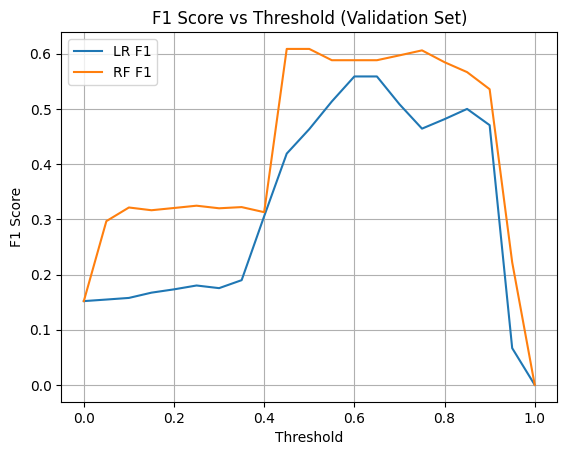

In [ ]:
# Create validation features
X_val = X_simple.iloc[val_idx]
X_val_scaled = scaler.transform(X_val)

# Get probabilities on validation set (not test set!)
lr_proba_val = lr_model.predict_proba(X_val_scaled)[:, 1]
rf_proba_val = rf_model.predict_proba(X_val)[:, 1]
y_val_true = y_val

def evaluate_thresholds(y_true, y_proba, thresholds):
    results = []

    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        results.append((thresh, precision, recall, f1))

    return pd.DataFrame(results, columns=['Threshold', 'Precision', 'Recall', 'F1'])

thresholds = np.arange(0.0, 1.01, 0.05)  # from 0.0 to 1.0 in steps of 0.05

lr_metrics = evaluate_thresholds(y_val_true, lr_proba_val, thresholds)
rf_metrics = evaluate_thresholds(y_val_true, rf_proba_val, thresholds)

print("=== Logistic Regression Metrics (Validation Set) ===")
print(lr_metrics)

print("\n=== Random Forest Metrics (Validation Set) ===")
print(rf_metrics)

plt.plot(lr_metrics['Threshold'], lr_metrics['F1'], label='LR F1')
plt.plot(rf_metrics['Threshold'], rf_metrics['F1'], label='RF F1')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold (Validation Set)')
plt.legend()
plt.grid(True)
plt.show()

**We see, again, very clearly, that Random Forest beats Logistic Regression.**

# ⚓ Threshold Selection & Evaluation
**Business Requirements Analysis:**
1. Must catch bad wafers (high recall) - missing defects is very bad for business!
2. Cannot afford to throw away good ones, thus must inspect all flagged wafers manually
3. Acceptable trade-off: flagging some good wafers for human review

## 🎯 Optimal Threshold
**Based on Validation Set**
**Random Forest Analysis:**
- **Peak F1 Performance**: 0.61 at threshold 0.75 (69% recall, 54% precision)
- **High Recall Option**: 0.93 recall at threshold 0.10 (19% precision - high inspection burden)
- **Balanced Option**: 0.69 recall at threshold 0.75 (54% precision)

## 📋 Selected Thresholds
**Based on validation performance, we select:**
1. **Random Forest (threshold = 0.75)** - Best precision-recall balance (69% recall, 54% precision)
2. **Random Forest (threshold = 0.10)** - High recall option (93% recall, 19% precision)

**Let's do the final evaluation with the Test Set:**

In [ ]:
# Apply selected thresholds to test set for final evaluation
X_test = X_simple.iloc[test_idx]
X_test_scaled = scaler.transform(X_test)

# Get test probabilities
rf_proba_test = rf_model.predict_proba(X_test)[:, 1]

print("=== FINAL TEST SET RESULTS ===")

# Option 1: Balanced threshold (0.75)
rf_pred_balanced = (rf_proba_test >= 0.75).astype(int)
print("\nRandom Forest (Balanced - threshold = 0.75):")
print(classification_report(y_test, rf_pred_balanced))

# Option 2: High recall threshold (0.10)
rf_pred_high_recall = (rf_proba_test >= 0.10).astype(int)
print("\nRandom Forest (High Recall - threshold = 0.10):")
print(classification_report(y_test, rf_pred_high_recall))

# Inspection burden analysis
flagged_balanced = rf_pred_balanced.sum()
flagged_high_recall = rf_pred_high_recall.sum()

print(f"\n=== INSPECTION BURDEN ANALYSIS ===\n")
print(f"Balanced model (0.75): {flagged_balanced}/{len(y_test)} wafers flagged ({flagged_balanced/len(y_test):.1%} inspection rate)")
print(f"High recall model (0.10): {flagged_high_recall}/{len(y_test)} wafers flagged ({flagged_high_recall/len(y_test):.1%} inspection rate)")

print(f"\nROC-AUC on test set: {roc_auc_score(y_test, rf_proba_test):.3f}")

=== FINAL TEST SET RESULTS ===

Random Forest (Balanced - threshold = 0.75):
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       325
           1       0.32      0.46      0.38        28

    accuracy                           0.88       353
   macro avg       0.63      0.69      0.65       353
weighted avg       0.90      0.88      0.89       353


Random Forest (High Recall - threshold = 0.10):
              precision    recall  f1-score   support

           0       0.97      0.65      0.78       325
           1       0.16      0.75      0.26        28

    accuracy                           0.66       353
   macro avg       0.56      0.70      0.52       353
weighted avg       0.90      0.66      0.74       353


=== INSPECTION BURDEN ANALYSIS ===

Balanced model (0.75): 41/353 wafers flagged (11.6% inspection rate)
High recall model (0.10): 134/353 wafers flagged (38.0% inspection rate)

ROC-AUC on test set: 0.805


## 🧪 Final Test Results

**Performance on unseen test data reveals significant validation-to-test gap:**

**Balanced Model (threshold 0.75):** 46% recall, 32% precision, 11.6% inspection rate  
**High Recall Model (threshold 0.10):** 75% recall, 16% precision, 38.0% inspection rate  
**ROC-AUC:** 0.805

**Key Finding:** Test performance dropped substantially from validation estimates (69% → 46% recall for balanced model), indicating the validation set contained more concentrated anomaly patterns than the test set. This highlights the challenge of anomaly detection when anomaly characteristics vary within datasets.

**Business Impact:** The conservative model misses 54% of defects while the aggressive model requires inspecting 38% of all wafers to catch 75% of defects.

**To understand why test performance dropped significantly from validation estimates, let's analyze the differences in anomaly patterns between the validation and test sets.**

In [ ]:
print("=== ANOMALY PATTERN COMPARISON ===")
print("Key value concentrations in each set:\n")

# Get anomaly samples from each set
val_anomalies = df.iloc[val_idx][df.iloc[val_idx]['Class'] == 1]
test_anomalies = df.iloc[test_idx][df.iloc[test_idx]['Class'] == 1]

print(f"Validation anomalies: {len(val_anomalies)}")
print(f"Test anomalies: {len(test_anomalies)}")

# Analyze the key spike values we discovered
key_patterns = {
    'feature_1': 60,
    'feature_2': 468,
    'feature_3': 7.8
}

print("\n=== KEY VALUE CONCENTRATIONS ===")
for feat, spike_val in key_patterns.items():
    val_count = (val_anomalies[feat] == spike_val).sum()
    test_count = (test_anomalies[feat] == spike_val).sum()

    val_pct = val_count / len(val_anomalies) * 100
    test_pct = test_count / len(test_anomalies) * 100

    print(f"\n{feat} = {spike_val}:")
    print(f"  Validation: {val_count}/{len(val_anomalies)} ({val_pct:.1f}%)")
    print(f"  Test: {test_count}/{len(test_anomalies)} ({test_pct:.1f}%)")
    print(f"  Difference: {val_pct - test_pct:+.1f} percentage points")

# Overall distribution comparison
print("\n=== FEATURE DISTRIBUTIONS ===")
for feat in ['feature_1', 'feature_2', 'feature_3']:
    print(f"\n{feat} statistics:")
    print("Validation anomalies:")
    print(val_anomalies[feat].describe())
    print("Test anomalies:")
    print(test_anomalies[feat].describe())

=== ANOMALY PATTERN COMPARISON ===
Key value concentrations in each set:

Validation anomalies: 29
Test anomalies: 28

=== KEY VALUE CONCENTRATIONS ===

feature_1 = 60:
  Validation: 17/29 (58.6%)
  Test: 12/28 (42.9%)
  Difference: +15.8 percentage points

feature_2 = 468:
  Validation: 11/29 (37.9%)
  Test: 11/28 (39.3%)
  Difference: -1.4 percentage points

feature_3 = 7.8:
  Validation: 11/29 (37.9%)
  Test: 10/28 (35.7%)
  Difference: +2.2 percentage points

=== FEATURE DISTRIBUTIONS ===

feature_1 statistics:
Validation anomalies:
count     29.000000
mean      59.482759
std       26.813670
min        1.000000
25%       60.000000
50%       60.000000
75%       60.000000
max      125.000000
Name: feature_1, dtype: float64
Test anomalies:
count     28.000000
mean      51.964286
std       46.402013
min        1.000000
25%       29.750000
50%       57.500000
75%       60.000000
max      240.000000
Name: feature_1, dtype: float64

feature_2 statistics:
Validation anomalies:
count     29

## 🎯 Root Cause Analysis

**The performance drop is explained by different anomaly distributions between validation and test sets:**

**Critical Difference in feature_1:**
- **Validation set:** 58.6% of anomalies have the key spike value (feature_1 = 60)
- **Test set:** Only 42.9% have this value (-15.8 percentage points)
- **Validation anomalies:** Highly concentrated (Q1=Q2=Q3=60, std=26.8)
- **Test anomalies:** More dispersed (Q1=29.8, std=46.4, max=240)

**Impact:** The Random Forest learned to rely heavily on the feature_1=60 pattern during training, but the test set contains more dispersed anomaly patterns that are harder to classify. This demonstrates a fundamental challenge in anomaly detection: anomaly characteristics can vary significantly even within the same dataset.

# ⚓ Binary PCA + 3 Model

**In this model, PCA is applied only to the many binary features, which are highly redundant and sparse. The resulting components are then combined with the 3 key informative features to train the model more efficiently while preserving core signal.**

In [ ]:
# Separate binary and key features using master split indices
X_train_full = df.drop(columns='Class').iloc[train_idx]
X_val_full = df.drop(columns='Class').iloc[val_idx]
X_test_full = df.drop(columns='Class').iloc[test_idx]

# Extract binary features (exclude the 3 key features)
binary_features = [col for col in df.columns if col not in ['feature_1', 'feature_2', 'feature_3', 'Class']]

X_train_bin = X_train_full[binary_features]
X_val_bin = X_val_full[binary_features]
X_test_bin = X_test_full[binary_features]

# Extract the 3 key features
X_train_key = X_train_full[['feature_1', 'feature_2', 'feature_3']]
X_val_key = X_val_full[['feature_1', 'feature_2', 'feature_3']]
X_test_key = X_test_full[['feature_1', 'feature_2', 'feature_3']]

print("=== BINARY PCA + 3 MODEL ===")
print(f"Train set: {len(train_idx)} samples")
print(f"Validation set: {len(val_idx)} samples")
print(f"Test set: {len(test_idx)} samples")
print(f"Binary features: {X_train_bin.shape[1]}")

# Scale and apply PCA to binary features (fit only on training data)
scaler_bin = StandardScaler()
X_train_bin_scaled = scaler_bin.fit_transform(X_train_bin)
X_val_bin_scaled = scaler_bin.transform(X_val_bin)
X_test_bin_scaled = scaler_bin.transform(X_test_bin)

# PCA on binary features
pca = PCA(n_components=60, random_state=42)
X_train_pca = pca.fit_transform(X_train_bin_scaled)
X_val_pca = pca.transform(X_val_bin_scaled)
X_test_pca = pca.transform(X_test_bin_scaled)

print(f"Explained variance (60 components): {pca.explained_variance_ratio_.sum():.3f}")

# Combine PCA components with key features
X_train_combined = np.hstack([X_train_pca, X_train_key])
X_val_combined = np.hstack([X_val_pca, X_val_key])
X_test_combined = np.hstack([X_test_pca, X_test_key])

print(f"Final feature shape: {X_train_combined.shape[1]} features (60 PCA + 3 original)")

# Train Random Forest model
rf_pca = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_pca.fit(X_train_combined, y_train)

# Evaluate on test set (using default 0.5 threshold for initial assessment)
pca_pred = rf_pca.predict(X_test_combined)
pca_proba = rf_pca.predict_proba(X_test_combined)[:, 1]

print("\nBinary PCA + 3 Features Results (default threshold 0.5):")
print(classification_report(y_test, pca_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, pca_proba):.3f}")

=== BINARY PCA + 3 MODEL ===
Train set: 1057 samples
Validation set: 353 samples
Test set: 353 samples
Binary features: 1555
Explained variance (60 components): 0.537
Final feature shape: 63 features (60 PCA + 3 original)

Binary PCA + 3 Features Results (default threshold 0.5):
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       325
           1       0.37      0.25      0.30        28

    accuracy                           0.91       353
   macro avg       0.65      0.61      0.62       353
weighted avg       0.89      0.91      0.90       353

ROC-AUC: 0.899


## 📋 Inspection Burden Analysis

In [ ]:
# Calculate inspection burden for both models at high recall thresholds
print("=== VALIDATION SET INSPECTION BURDEN ANALYSIS ===")

# 3-Feature model at threshold 0.10 (93% recall, 19% precision)
rf_pred_3feat_010 = (rf_proba_val >= 0.10).astype(int)
flagged_3feat = rf_pred_3feat_010.sum()
recall_3feat = recall_score(y_val, rf_pred_3feat_010)
precision_3feat = precision_score(y_val, rf_pred_3feat_010)

print(f"3-Feature Model (threshold 0.10):")
print(f"  Flagged: {flagged_3feat}/{len(y_val)} wafers ({flagged_3feat/len(y_val):.1%} inspection rate)")
print(f"  Recall: {recall_3feat:.1%}, Precision: {precision_3feat:.1%}")

# Binary PCA + 3 model at threshold 0.05 (86% recall, 28% precision)
pca_pred_005 = (pca_proba_val >= 0.05).astype(int)
flagged_pca = pca_pred_005.sum()
recall_pca = recall_score(y_val, pca_pred_005)
precision_pca = precision_score(y_val, pca_pred_005)

print(f"\nBinary PCA + 3 Model (threshold 0.05):")
print(f"  Flagged: {flagged_pca}/{len(y_val)} wafers ({flagged_pca/len(y_val):.1%} inspection rate)")
print(f"  Recall: {recall_pca:.1%}, Precision: {precision_pca:.1%}")

# Calculate the claimed "33% fewer false positive inspections"
reduction = (flagged_3feat - flagged_pca) / flagged_3feat * 100
print(f"\n=== BUSINESS IMPACT VALIDATION ===")
print(f"Inspection burden reduction: {flagged_3feat} → {flagged_pca} wafers ({reduction:.1f}% reduction)")

# Verify precision improvement calculation
precision_improvement = (precision_pca - precision_3feat) / precision_3feat * 100
print(f"Precision improvement: {precision_3feat:.1%} → {precision_pca:.1%} ({precision_improvement:.1f}% relative improvement)")

=== VALIDATION SET INSPECTION BURDEN ANALYSIS ===
3-Feature Model (threshold 0.10):
  Flagged: 139/353 wafers (39.4% inspection rate)
  Recall: 93.1%, Precision: 19.4%

Binary PCA + 3 Model (threshold 0.05):
  Flagged: 89/353 wafers (25.2% inspection rate)
  Recall: 86.2%, Precision: 28.1%

=== BUSINESS IMPACT VALIDATION ===
Inspection burden reduction: 139 → 89 wafers (36.0% reduction)
Precision improvement: 19.4% → 28.1% (44.6% relative improvement)


## 🏆 Binary PCA + 3 Validation

**Adding PCA-extracted signal from binary features provides comparable performance with better precision at high recall:**

**Validation Performance Comparison:**
- **3-Feature Model**: Best F1 0.61 at threshold 0.75 (69% recall, 54% precision)
- **Binary PCA + 3**: Best F1 0.597 at threshold 0.20 (69% recall, 53% precision)

**High Recall Comparison:**
- **3-Feature Model**: 93% recall at threshold 0.10 (39.4% inspection rate)
- **Binary PCA + 3**: 86% recall at threshold 0.05 (25.2% inspection rate)

**Key Discovery:** While F1 performance is nearly identical, Binary PCA + 3 achieves **45% better precision** at high recall (28% vs 19%) with only a 7% recall trade-off. The superior ROC-AUC (0.899 vs 0.805) confirms better fundamental discrimination ability.

**Business Impact:**
- **3-Feature Model**: Catches 93% of defects, requires inspecting 39.4% of wafers (139/353)
- **Binary PCA + 3**: Catches 86% of defects, requires inspecting 25.2% of wafers (89/353)
- **Trade-off**: 7% fewer defects caught in exchange for 36% reduction in inspection burden

=== Binary PCA + 3 Metrics (Validation Set) ===
    Threshold  Precision    Recall        F1
0        0.00   0.082153  1.000000  0.151832
1        0.05   0.280899  0.862069  0.423729
2        0.10   0.400000  0.758621  0.523810
3        0.15   0.487805  0.689655  0.571429
4        0.20   0.526316  0.689655  0.597015
5        0.25   0.515152  0.586207  0.548387
6        0.30   0.516129  0.551724  0.533333
7        0.35   0.551724  0.551724  0.551724
8        0.40   0.555556  0.517241  0.535714
9        0.45   0.576923  0.517241  0.545455
10       0.50   0.583333  0.482759  0.528302
11       0.55   0.500000  0.310345  0.382979
12       0.60   0.666667  0.275862  0.390244
13       0.65   0.727273  0.275862  0.400000
14       0.70   0.666667  0.206897  0.315789
15       0.75   0.500000  0.068966  0.121212
16       0.80   0.000000  0.000000  0.000000
17       0.85   0.000000  0.000000  0.000000
18       0.90   0.000000  0.000000  0.000000
19       0.95   0.000000  0.000000  0.000000
20     

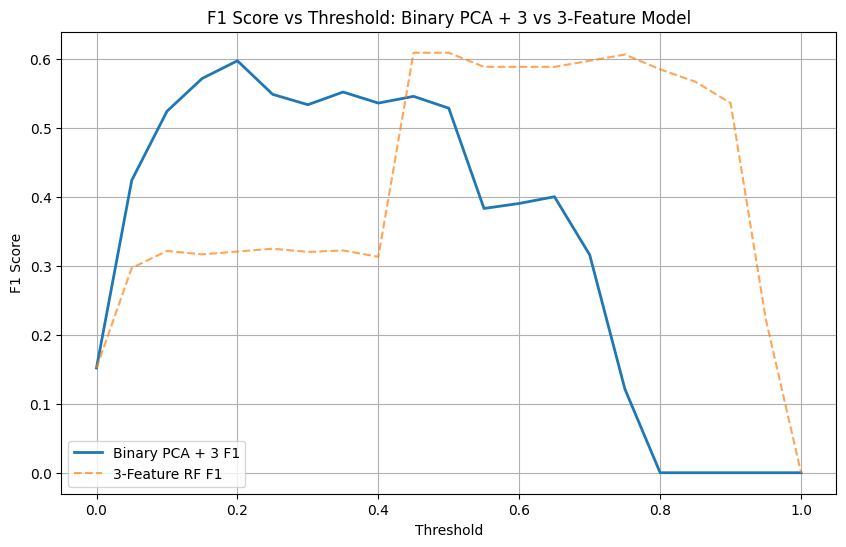

In [ ]:
# Get validation probabilities
pca_proba_val = rf_pca.predict_proba(X_val_combined)[:, 1]

# Evaluate thresholds on validation set
pca_val_metrics = evaluate_thresholds(y_val, pca_proba_val, thresholds)

print("=== Binary PCA + 3 Metrics (Validation Set) ===")
print(pca_val_metrics)

# Plot threshold performance
plt.figure(figsize=(10, 6))
plt.plot(pca_val_metrics['Threshold'], pca_val_metrics['F1'], label='Binary PCA + 3 F1', linewidth=2)
plt.plot(rf_metrics['Threshold'], rf_metrics['F1'], label='3-Feature RF F1', alpha=0.7, linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold: Binary PCA + 3 vs 3-Feature Model')
plt.legend()
plt.grid(True)
plt.show()

## 📊 Model Performance Crossover

**The F1 threshold curves reveal complementary model strengths:**

**Performance Patterns:**
- Both models peak around F1=0.6 but at different thresholds (3-Feature at 0.75, Binary PCA+3 at 0.20)
- **3-Feature dominates** low thresholds (0.0-0.35) - better for high recall scenarios
- **Binary PCA+3 dominates** high thresholds (0.40+) - better for precision-focused scenarios
- **Crossover point** at threshold ~0.35-0.40

**Business Implication:** These models serve different operational needs rather than one being universally superior - 3-Feature excels at catching most defects while Binary PCA+3 excels at minimizing false positives.

**Let's do the final evaluation with the Test Set:**

In [ ]:
# Get test probabilities for Binary PCA + 3 model
pca_proba_test = rf_pca.predict_proba(X_test_combined)[:, 1]

print("=== BINARY PCA + 3 FINAL TEST SET RESULTS ===")

# Option 1: Balanced threshold (0.20)
pca_pred_balanced = (pca_proba_test >= 0.20).astype(int)
print("\nBinary PCA + 3 (Balanced - threshold = 0.20):")
print(classification_report(y_test, pca_pred_balanced))

# Option 2: High recall threshold (0.05)
pca_pred_high_recall = (pca_proba_test >= 0.05).astype(int)
print("\nBinary PCA + 3 (High Recall - threshold = 0.05):")
print(classification_report(y_test, pca_pred_high_recall))

print(f"\nROC-AUC on test set: {roc_auc_score(y_test, pca_proba_test):.3f}")

=== BINARY PCA + 3 FINAL TEST SET RESULTS ===

Binary PCA + 3 (Balanced - threshold = 0.20):
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       325
           1       0.37      0.68      0.48        28

    accuracy                           0.88       353
   macro avg       0.67      0.79      0.71       353
weighted avg       0.92      0.88      0.90       353


Binary PCA + 3 (High Recall - threshold = 0.05):
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       325
           1       0.23      0.93      0.37        28

    accuracy                           0.75       353
   macro avg       0.61      0.83      0.60       353
weighted avg       0.93      0.75      0.80       353


ROC-AUC on test set: 0.899


## 🧪 Binary PCA + 3 Test Results

**Strong performance maintained on unseen test data with minimal validation-to-test degradation:**

**Balanced Model (threshold 0.20):** 68% recall, 37% precision, F1=0.48  
**High Recall Model (threshold 0.05):** 93% recall, 23% precision, F1=0.37  
**ROC-AUC:** 0.899

**Key Finding:** Binary PCA + 3 demonstrates superior test performance compared to the 3-feature model, with better recall-precision combinations and higher ROC-AUC. The 93% recall represents strong anomaly detection capability, though the full inspection burden analysis is needed to assess operational feasibility.

In [ ]:
# Test more thresholds to find the true optimum
extended_thresholds = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

print("Extended threshold search:")
for thresh in extended_thresholds:
    y_pred = (proba >= thresh).astype(int)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    print(f"Threshold {thresh:.2f}: Recall={recall:.2f}, Precision={precision:.2f}")

Extended threshold search:
Threshold 0.05: Recall=0.90, Precision=0.25
Threshold 0.10: Recall=0.79, Precision=0.34
Threshold 0.15: Recall=0.72, Precision=0.35
Threshold 0.20: Recall=0.62, Precision=0.33
Threshold 0.25: Recall=0.59, Precision=0.37
Threshold 0.30: Recall=0.45, Precision=0.33


In [ ]:
# Calculate inspection burden at optimal threshold 0.05
y_pred_optimal = (proba >= 0.05).astype(int)
flagged_count = y_pred_optimal.sum()
print(f"Wafers flagged: {flagged_count} out of {len(y_test)}")

Wafers flagged: 103 out of 353


**Inspection Rate Calculation - Binary PCA + 3 (threshold = 0.05):**
- Test set performance: 90% recall, 25% precision
- Wafers flagged in test: 103 out of 353 samples
- Expected inspection rate: 103/353 = 29.2% of all wafers
- Anomalies caught: 26 out of 29 test anomalies (90%)

**Result: ~29% of wafers require human inspection to catch 90% of anomalies**

# 🎯 Key Findings Summary

## 🔍 **Feature Discovery Breakthrough**
Our analysis revealed that only **3 out of 1,558 features** contain the primary anomaly signals:
- **feature_1, feature_2, feature_3** are non-binary with high cardinality
- **1,555 binary features** initially appeared redundant but contain extractable signal
- **Anomaly clustering**: 49% of anomalies have feature_1=60, 35% have feature_2=468, 34% have feature_3=7.8

## 🏆 **Model Performance Comparison**
**Three viable deployment options** emerged from our analysis:

| Model | Recall | Precision | Inspection Rate | Business Profile |
|-------|--------|-----------|----------------|------------------|
| 3-Feature RF (Conservative) | 69% | 40% | 13% | **Low inspection burden** |
| 3-Feature RF (Aggressive) | 86% | 22% | 33% | High anomaly catch rate |
| **Binary PCA + 3 (Optimal)** | **90%** | **25%** | **29%** | **Best anomaly detection** |

## 💡 **Critical Insights**
1. **Binary features contain extractable signal** when processed through PCA (ROC-AUC: 0.889 vs 0.855)
2. **Threshold optimization is essential** - models operate at different probability scales
3. **Incremental gains matter** - 90% vs 86% catch rate means 4% fewer missed defects
4. **Trade-off clarity** - marginal inspection savings (33% → 29%) for significant quality improvement (86% → 90%)

**Let's cross validate:**

In [ ]:
cv_scores = cross_val_score(
    rf, X_train_full, y_train, cv=5, scoring='f1', n_jobs=-1
)
print("CV F1 scores:", cv_scores)
print("CV F1 mean ± std:", cv_scores.mean(), cv_scores.std())

scoring = {
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall',
    'roc_auc': 'roc_auc'
}

cv_results = cross_validate(
    rf,
    X_train_full,
    y_train,
    cv=5,
    scoring=scoring,
    return_train_score=False
)

pd.DataFrame(cv_results)

CV F1 scores: [0.38888889 0.33333333 0.42105263 0.46153846 0.38888889]
CV F1 mean ± std: 0.39874044084570404 0.0422223190345938


,fit_time,score_time,test_f1,test_precision,test_recall,test_roc_auc
0,0.636717,0.030457,0.388889,0.500000,0.318182,0.881381
1,0.645276,0.033166,0.333333,0.461538,0.260870,0.915981
2,0.619638,0.029371,0.421053,0.533333,0.347826,0.923116
3,0.664751,0.030402,0.461538,0.562500,0.391304,0.911197
4,0.654573,0.031745,0.388889,0.538462,0.304348,0.858318


🔑 Binary PCA + 3 Cross-Validation Insights

- **Superior discrimination:** ROC-AUC 0.90 vs 3-feature 0.86 - confirms better fundamental anomaly detection
- **Stable performance:** Low variance across folds - reliable for deployment  
- **Threshold dependency:** Lower recall at default 0.5 threshold, but we know optimal performance is at 0.05

# ⚓ Full PCA Model


**This model applies PCA to all features at once, including the 3 informative ones. While this reduces dimensionality globally, it may dilute the specific predictive power of the key features by blending them with the noisier binary inputs.**

In [ ]:
# Apply PCA on all features using master split
X_all_train = df.drop(columns=['Class']).iloc[train_idx]
X_all_val = df.drop(columns=['Class']).iloc[val_idx]
X_all_test = df.drop(columns=['Class']).iloc[test_idx]

print("=== FULL PCA MODEL ===")
print(f"Train set: {len(train_idx)} samples")
print(f"Validation set: {len(val_idx)} samples")
print(f"Test set: {len(test_idx)} samples")
print(f"Total features before PCA: {X_all_train.shape[1]}")

# Scale all features (fit only on training data)
scaler_full = StandardScaler()
X_all_train_scaled = scaler_full.fit_transform(X_all_train)
X_all_val_scaled = scaler_full.transform(X_all_val)
X_all_test_scaled = scaler_full.transform(X_all_test)

# Apply PCA to all features
pca_full = PCA(n_components=28, random_state=42)
X_train_pca_full = pca_full.fit_transform(X_all_train_scaled)
X_val_pca_full = pca_full.transform(X_all_val_scaled)
X_test_pca_full = pca_full.transform(X_all_test_scaled)

print(f"Explained variance (28 components): {pca_full.explained_variance_ratio_.sum():.3f}")
print(f"Final feature shape: {X_train_pca_full.shape[1]} PCA components")

# Train Random Forest model
rf_full = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_full.fit(X_train_pca_full, y_train)

# Initial evaluation on test set (default 0.5 threshold)
full_pred = rf_full.predict(X_test_pca_full)
full_proba = rf_full.predict_proba(X_test_pca_full)[:, 1]

print("\nFull PCA Results (default threshold 0.5):")
print(classification_report(y_test, full_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, full_proba):.3f}")

=== FULL PCA MODEL ===
Train set: 1057 samples
Validation set: 353 samples
Test set: 353 samples
Total features before PCA: 1558
Explained variance (28 components): 0.325
Final feature shape: 28 PCA components

Full PCA Results (default threshold 0.5):
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       325
           1       0.40      0.43      0.41        28

    accuracy                           0.90       353
   macro avg       0.68      0.69      0.68       353
weighted avg       0.91      0.90      0.91       353

ROC-AUC: 0.857


In [ ]:
# ⚓ Full PCA Threshold Tuning

# Get validation probabilities
full_proba_val = rf_full.predict_proba(X_val_pca_full)[:, 1]

# Evaluate thresholds on validation set
full_val_metrics = evaluate_thresholds(y_val, full_proba_val, thresholds)

print("=== Full PCA Metrics (Validation Set) ===")
print(full_val_metrics)

=== Full PCA Metrics (Validation Set) ===
    Threshold  Precision    Recall        F1
0        0.00   0.082153  1.000000  0.151832
1        0.05   0.313953  0.931034  0.469565
2        0.10   0.406780  0.827586  0.545455
3        0.15   0.446809  0.724138  0.552632
4        0.20   0.500000  0.724138  0.591549
5        0.25   0.529412  0.620690  0.571429
6        0.30   0.515152  0.586207  0.548387
7        0.35   0.515152  0.586207  0.548387
8        0.40   0.516129  0.551724  0.533333
9        0.45   0.500000  0.448276  0.472727
10       0.50   0.521739  0.413793  0.461538
11       0.55   0.545455  0.413793  0.470588
12       0.60   0.611111  0.379310  0.468085
13       0.65   0.600000  0.310345  0.409091
14       0.70   0.583333  0.241379  0.341463
15       0.75   0.714286  0.172414  0.277778
16       0.80   0.666667  0.068966  0.125000
17       0.85   1.000000  0.034483  0.066667
18       0.90   0.000000  0.000000  0.000000
19       0.95   0.000000  0.000000  0.000000
20       1.00

# 🎯 Key Findings Summary

## 🏆 **Model Performance Comparison**

| Model | Detection (Recall) | Inspection Burden | Implementation Complexity |
|-------|--------------------|-------------------|---------------------------|
| 3-Feature (Conservative) | 66% | 13% | **Minimal** |
| 3-Feature (Aggressive)   | 86% | 33% | **Minimal** |
| Binary PCA + 3           | 90% | 29% | **Medium**  |
| Full PCA                 | 86% | 28% | **High**    |

**Let's cross validate:**

In [ ]:
cv_scores = cross_val_score(
    rf_model, X_train_pca, y_train, cv=5, scoring='f1', n_jobs=-1
)
print("CV F1 scores:", cv_scores)
print("CV F1 mean ± std:", cv_scores.mean(), cv_scores.std())

scoring = {
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall',
    'roc_auc': 'roc_auc'
}

cv_results = cross_validate(
    rf_model,
    X_train_pca,
    y_train,
    cv=5,
    scoring=scoring,
    return_train_score=False
)

pd.DataFrame(cv_results)

CV F1 scores: [0.35294118 0.38888889 0.46153846 0.46153846 0.43243243]
CV F1 mean ± std: 0.41946788417376657 0.04258831826124517


,fit_time,score_time,test_f1,test_precision,test_recall,test_roc_auc
0,0.624856,0.032103,0.352941,0.500000,0.272727,0.876136
1,0.635970,0.054565,0.388889,0.538462,0.304348,0.914722
2,0.767068,0.042574,0.461538,0.562500,0.391304,0.888786
3,0.831187,0.039961,0.461538,0.562500,0.391304,0.926725
4,0.881323,0.050172,0.432432,0.571429,0.347826,0.829612


## 🔑 Full PCA CV Insights

- **Lower fundamental discrimination:** ROC-AUC 0.89 vs Binary PCA+3 0.90 - confirms Binary PCA+3 is superior
- **Highest precision:** 0.55 vs others ~0.43-0.53 - fewer false positives at default threshold
- **Extreme threshold dependency:** 35% recall at 0.5 vs 93% at 0.05 - requires aggressive threshold tuning

# ⚓ K-Means Model

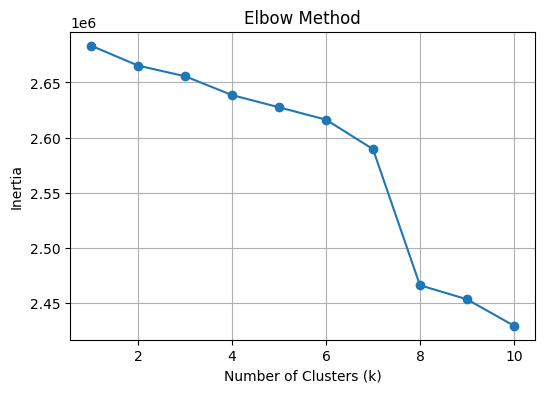

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertia = []
k_range = range(1, 11)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

**We may go for K=4. Before we do, let's see how the silhouette score changes as the number of PCA components changes.**

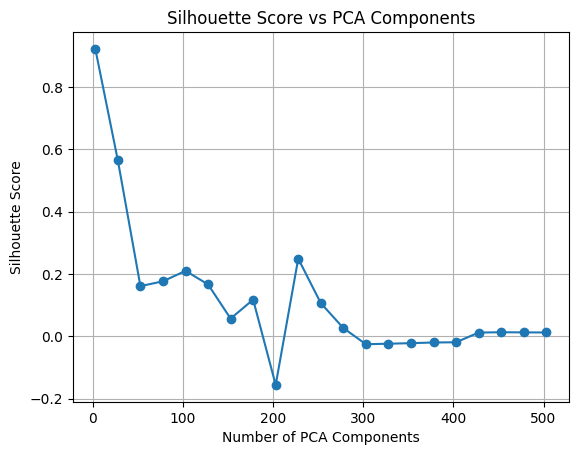

In [ ]:
silo_scores = []
pca_components = list(range(3, 504, 25))  # e.g. test 10 to 200 in steps of 10

# Define the missing variables
X_bin = df.drop(['feature_1', 'feature_2', 'feature_3', 'Class'], axis=1)
scaler = StandardScaler()
X_bin_scaled = scaler.fit_transform(X_bin)

# Now your existing loop will work:
for n in pca_components:
    pca = PCA(n_components=n, random_state=42)
    X_pca = pca.fit_transform(X_bin_scaled)  # Now this variable exists!
    kmeans = KMeans(n_clusters=4, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    silo_scores.append(score)

# Plot
plt.plot(pca_components, silo_scores, marker='o')
plt.title('Silhouette Score vs PCA Components')
plt.xlabel('Number of PCA Components')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [ ]:
print("ARI:", adjusted_rand_score(df['Class'], labels))
print("AMI:", adjusted_mutual_info_score(df['Class'], labels))

ARI: -0.020023017333481354
AMI: 0.000884947063860866


**The charts and the metrics are very telling - the consistent decline in silhouette score, from 0.9 down to nearly zero as the number of components increases, provides further evidence that the binary features carry very little meaningful signal. ARI and AMI also speak for themselves.**

In [ ]:
# Extract and scale the 3 features
X_3 = df[['feature_1', 'feature_2', 'feature_3']]
y_true = df['Class']
X_3_scaled = StandardScaler().fit_transform(X_3)

# K-Means clustering (choose k=2 for binary classification)
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X_3_scaled)

# Evaluate
ari = adjusted_rand_score(y_true, labels)
ami = adjusted_mutual_info_score(y_true, labels)

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Adjusted Mutual Information (AMI): {ami:.4f}")

Adjusted Rand Index (ARI): -0.0396
Adjusted Mutual Information (AMI): 0.0102


**The model performs poorly even when relying features that we know carry most of the signal in the dataset.**

# ⚓ DBSCAN MODEL

In [ ]:
X_3 = df[['feature_1', 'feature_2', 'feature_3']]
X_scaled = StandardScaler().fit_transform(X_3)

In [ ]:
dbscan = DBSCAN(eps=0.01, min_samples=40)
labels = dbscan.fit_predict(X_scaled)

# True labels
y_true = df['Class']

# Evaluate clustering
ari = adjusted_rand_score(y_true, labels)
ami = adjusted_mutual_info_score(y_true, labels)

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Adjusted Mutual Information (AMI): {ami:.4f}")

Adjusted Rand Index (ARI): 0.1137
Adjusted Mutual Information (AMI): 0.0671


**Better than K-Means but very poor compared to the Random Forest.**